In [215]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import math
from scipy.fft import fft, fftfreq
from scipy.signal import argrelmax, spectrogram, correlate, correlate2d
from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
from datetime import timedelta
sns.set()

# Synthetic Data Analysis

## Data Overview

### Imports

In [44]:
# Load the dataset
file_path = "acquisitions/synthetic_test/processed/processed_all_actions.csv"
ref_file_path = "acquisitions/synthetic_test/processed/processed_combined_acquisition_2024-01-14_21-20-48.csv"
# Import the CSV file into a DataFrame
df = pd.read_csv(file_path)
df_ref = pd.read_csv(ref_file_path)

# convert _time column to datetime
df['_time'] = pd.to_datetime(df['_time'])
df_ref['_time'] = pd.to_datetime(df_ref['_time'])

### Raw Data Analysis

##### Functions

In [45]:
# function to calculate correlation matrix of one series
def plot_correlation_matrix(data, action):

    # Getting the series ID for the action
    series_id = data[data['action'] == action]['series_id'].iloc[0]
    # Filter data for the specific series_id and action
    filtered_data = data[(data['series_id'] == series_id) & (data['action'] == action)]
    # Select only float columns
    numeric_data = filtered_data.select_dtypes(include=[np.float64])

    # Calculate the correlation matrix
    corr_matrix = numeric_data.corr()

    # Plotting the heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Correlation Matrix for Series ID {series_id} and Action {action}')
    plt.show()

In [46]:
def plot_sensors_df(df, title="", x_index='sample'):
    """
    Plot the sensors data in a 4x3 subplots
    """
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle(title)

    for i, column in enumerate(columns):

        if x_index == 'sample':
            axs[i//3, i%3].plot(df[column], color='C'+str(i%3), label=column)
        else:
            axs[i//3, i%3].plot(df[x_index], df[column], color='C'+str(i%3), label=column)
            
        axs[i//3, i%3].legend()
        # axs[i//3, i%3].set_title(column)

        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')

    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

##### Code

In [47]:
df.head()

_time  series_id  measurement_id      action    gyro_x  \
0 2023-12-29 16:50:56.247487          0               0  floating_x  1.865854   
1 2023-12-29 16:50:56.262481          0               1  floating_x  1.865854   
2 2023-12-29 16:50:56.276026          0               2  floating_x  1.743902   
3 2023-12-29 16:50:56.291837          0               3  floating_x  0.280488   
4 2023-12-29 16:50:56.306791          0               4  floating_x -0.878049   

     gyro_y    gyro_z   accel_x   accel_y   accel_z  quat_x  quat_y  quat_z  \
0  0.323171  0.243902  0.004321 -0.004956  0.010840    -0.7    0.68    0.21   
1  0.323171  0.243902  0.004321 -0.004956  0.010840    -0.7    0.68    0.21   
2 -0.164634  0.182927  0.004077  0.000659  0.006201    -0.7    0.68    0.21   
3 -1.506098  0.243902  0.003345 -0.003735 -0.007471    -0.7    0.68    0.21   
4 -1.567073 -0.060976  0.004565 -0.008130 -0.011377    -0.7    0.68    0.21   

   quat_w  
0     0.1  
1     0.1  
2     0.1  
3     0.1  
4     0.1

In [48]:
df.describe()

_time    series_id  measurement_id  \
count                           3457  3457.000000     3457.000000   
mean   2023-12-29 16:57:36.316104448     5.216951      170.265259   
min       2023-12-29 16:49:52.689785     0.000000        0.000000   
25%    2023-12-29 16:52:47.497299968     2.000000       72.000000   
50%    2023-12-29 16:56:23.786156032     5.000000      149.000000   
75%    2023-12-29 17:02:53.938644992     9.000000      248.000000   
max       2023-12-29 17:08:48.633000    11.000000      500.000000   
std                              NaN     3.722790      121.300390   

            gyro_x       gyro_y       gyro_z      accel_x      accel_y  \
count  3457.000000  3457.000000  3457.000000  3457.000000  3457.000000   
mean     -4.114510     0.755942    -0.869745    -0.106049    -0.097238   
min    -777.884146  -337.158537  -232.682927    -1.948242    -2.094897   
25%      -8.073171    -9.926829   -15.280488    -0.266504    -0.099365   
50%       0.146341     0.030488    -0.146341    -0.001611    -0.008472   
75%      15.128049    10.182927     6.024390     0.033301     0.009595   
max     203.975610   576.463415   715.134146     1.710742     0.819019   
std      71.090067    74.537029    65.122563     0.437289     0.338756   

           accel_z       quat_x       quat_y       quat_z       quat_w  
count  3457.000000  3457.000000  3457.000000  3457.000000  3457.000000  
mean      0.046940     0.051449     0.272953     0.070223     0.254709  
min      -0.991528    -0.980000    -0.980000    -0.990000     0.000000  
25%      -0.023169    -0.610000    -0.210000    -0.170000     0.070000  
50%       0.007153     0.210000     0.530000     0.100000     0.180000  
75%       0.091650     0.640000     0.690000     0.320000     0.430000  
max       2.023047     0.990000     0.990000     1.000000     0.970000  
std       0.441120     0.630403     0.530645     0.357432     0.216536

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   _time           3457 non-null   datetime64[ns]
 1   series_id       3457 non-null   int64         
 2   measurement_id  3457 non-null   int64         
 3   action          3457 non-null   object        
 4   gyro_x          3457 non-null   float64       
 5   gyro_y          3457 non-null   float64       
 6   gyro_z          3457 non-null   float64       
 7   accel_x         3457 non-null   float64       
 8   accel_y         3457 non-null   float64       
 9   accel_z         3457 non-null   float64       
 10  quat_x          3457 non-null   float64       
 11  quat_y          3457 non-null   float64       
 12  quat_z          3457 non-null   float64       
 13  quat_w          3457 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(2), object(1)
m

In [50]:
# groupby by action
df_grouped = df.groupby('action')

# Grouping data by series_id and action
df_grouped_id = df.groupby(['series_id', 'action']).size().unstack(fill_value=0)
# show all the actions
# print(df_grouped.groups.keys())

Check how many samples there are in each sequence.

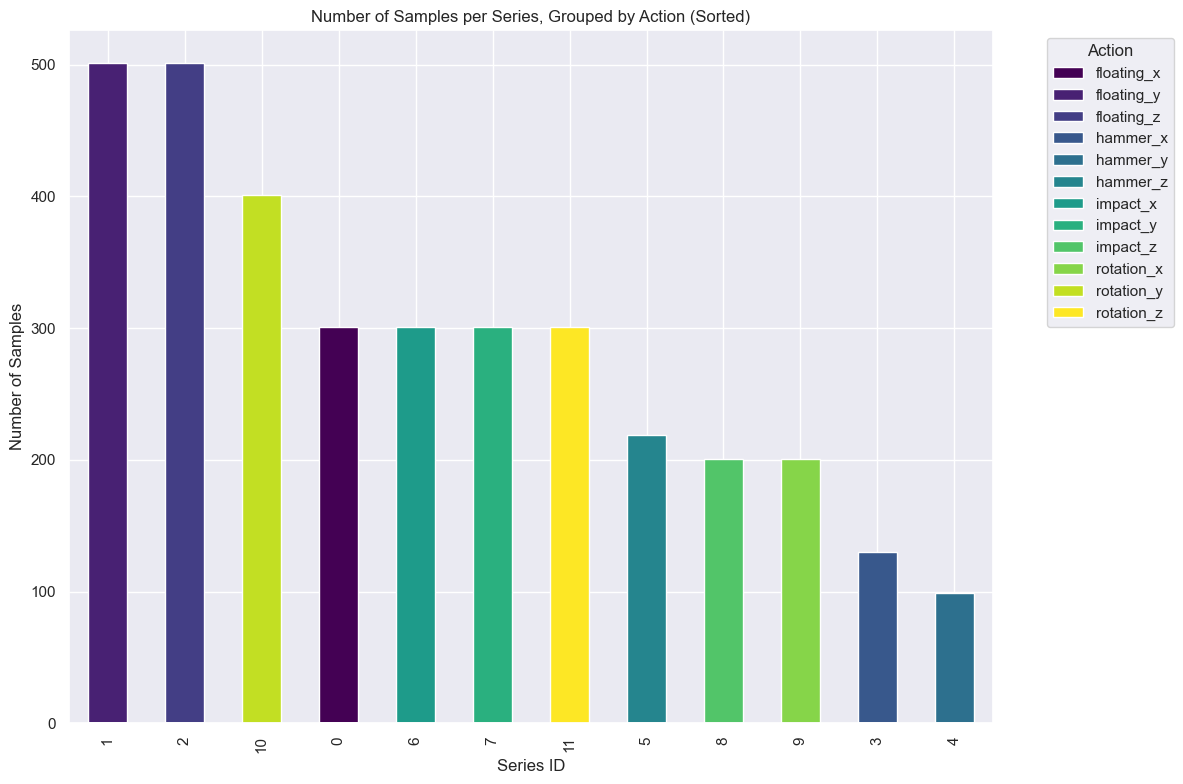

In [51]:

# Sorting the grouped data by the total number of samples in each series, from highest to lowest
sorted_grouped_data = df_grouped_id.sum(axis=1).sort_values(ascending=False)
sorted_grouped_data = df_grouped_id.loc[sorted_grouped_data.index]

# Plotting the sorted histogram
ax = sorted_grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Number of Samples per Series, Grouped by Action (Sorted)')
plt.xlabel('Series ID')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

Correlation matrix to see the relations among features for each sequence

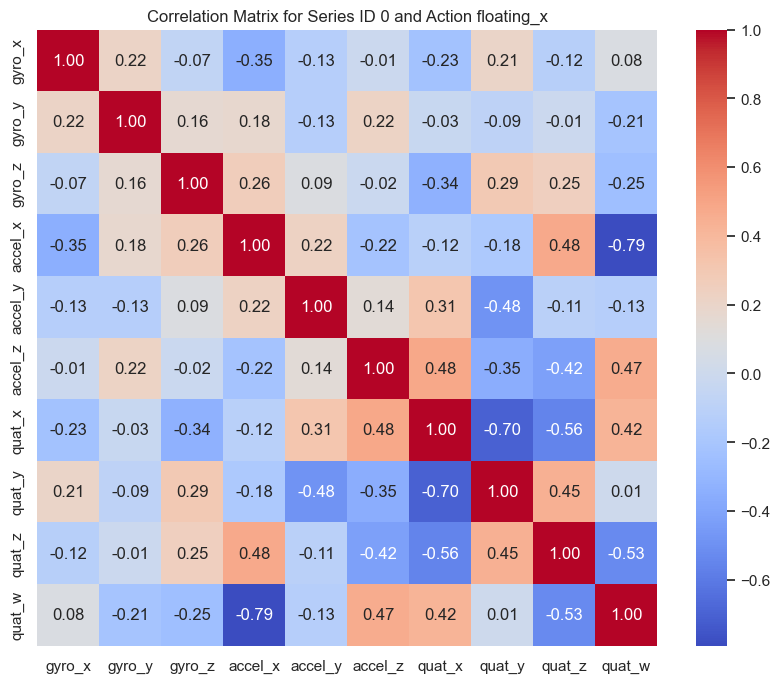

In [52]:
plot_correlation_matrix(df,'floating_x')
# plot_correlation_matrix(df,'floating_y')
# plot_correlation_matrix(df,'floating_z')
# plot_correlation_matrix(df,'hammer_x')
# plot_correlation_matrix(df,'hammer_y')
# plot_correlation_matrix(df,'hammer_z')
# plot_correlation_matrix(df,'impact_x')
# plot_correlation_matrix(df,'impact_y')
# plot_correlation_matrix(df,'impact_z')
# plot_correlation_matrix(df,'rotation_x')
# plot_correlation_matrix(df,'rotation_y')
# plot_correlation_matrix(df,'rotation_z')


In [53]:
df_time = df.copy()
df_time['time_diff'] = df_time.groupby('series_id')['_time'].diff()
df_time = df_time.dropna()
df_time['time_diff_seconds'] = df_time['time_diff'].dt.total_seconds()

Visualize the sampling time difference distribution for each sequence

In [54]:
# Create a mapping of series_id to action
action_mapping = df_time.dropna().groupby('series_id')['action'].first().to_dict()

# Setting up the color palette to match the histogram colors
palette = sns.color_palette('viridis', n_colors=len(df_time['series_id'].unique()))

# Plotting Gaussian distributions with the same colors as the histogram
plt.figure(figsize=(12, 8))

# Generating Gaussian plots for each series
for idx, series_id in enumerate(sorted(df_time['series_id'].unique())):
    # Selecting the series
    series_data = df_time[df_time['series_id'] == series_id]['time_diff_seconds']
    
    # Calculating mean and standard deviation
    mean = series_data.mean()
    std = series_data.std()
    
    # Generating points for the Gaussian curve
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    
    # Plotting with action name in the label
    action_name = action_mapping.get(series_id, 'Unknown')
    plt.plot(x, y, label=f'{action_name}', color=palette[idx])

# Adding title, labels, and legend
plt.title('Gaussian Distributions of Time Differences for Each Series')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Probability Density')
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
# show bar on top of grid
plt.gca().set_axisbelow(True)
# Show plot
plt.show()

# print the mean and standard deviation of the time differences for each series
series_mean = []
series_std = []

for series_id in df_time['series_id'].unique():
    series_data = df_time[df_time['series_id'] == series_id]['time_diff_seconds']
    series_mean.append(series_data.mean())
    series_std.append(series_data.std())
    # print(f'Series {series_id}: mean = {series_data.mean()}, std = {series_data.std()}')

print('-------------------')

# print minimum and maximum mean and standard deviation
print(f'Minimum mean: {min(series_mean)}')
print(f'Maximum mean: {max(series_mean)}')
print(f'Minimum std: {min(series_std)}')
print(f'Maximum std: {max(series_std)}')

print('-------------------')

print(f'Slowest sampling time: {round(max(series_mean), 2)} seconds')
print(f'Fastest sampling time: {round(min(series_mean), 2)} seconds')

-------------------
Minimum mean: 0.021462023255813957
Maximum mean: 0.04959692666666667
Minimum std: 0.022060028831696925
Maximum std: 0.045933133781250725
-------------------
Slowest sampling time: 0.05 seconds
Fastest sampling time: 0.02 seconds


In [55]:
df_floatingx = df_grouped.get_group('floating_x')
df_floatingy = df_grouped.get_group('floating_y')
df_floatingz = df_grouped.get_group('floating_z')
df_hammerx = df_grouped.get_group('hammer_x')
df_hammery = df_grouped.get_group('hammer_y')
df_hammerz = df_grouped.get_group('hammer_z')
df_impactx = df_grouped.get_group('impact_x')
df_impacty = df_grouped.get_group('impact_y')
df_impactz = df_grouped.get_group('impact_z')
df_rotationx = df_grouped.get_group('rotation_x')
df_rotationy = df_grouped.get_group('rotation_y')
df_rotationz = df_grouped.get_group('rotation_z')

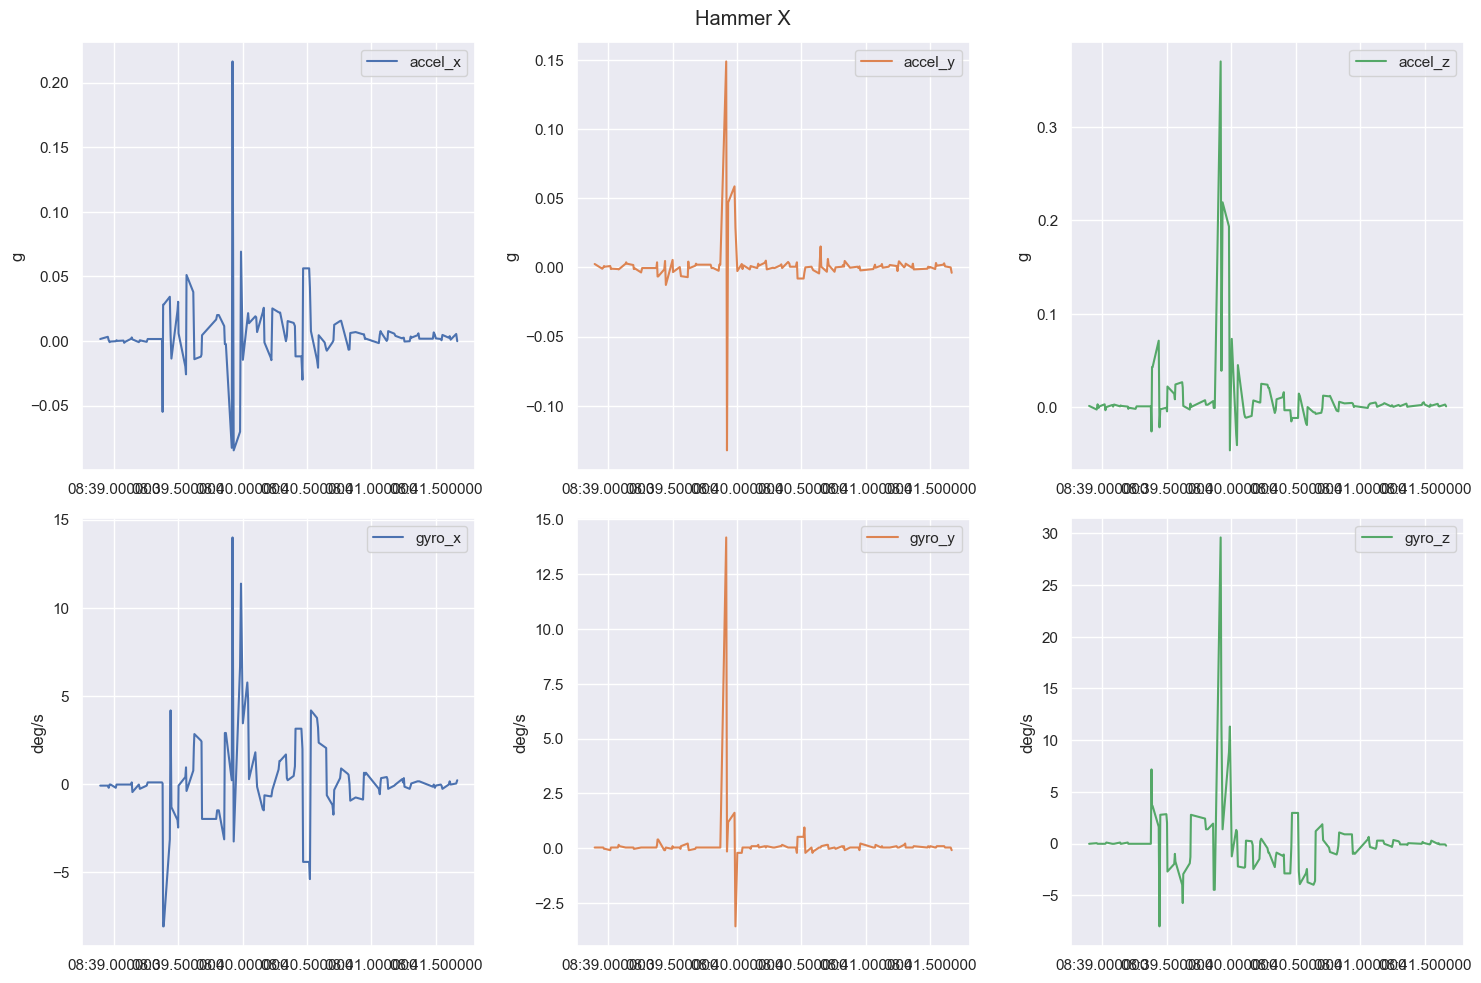

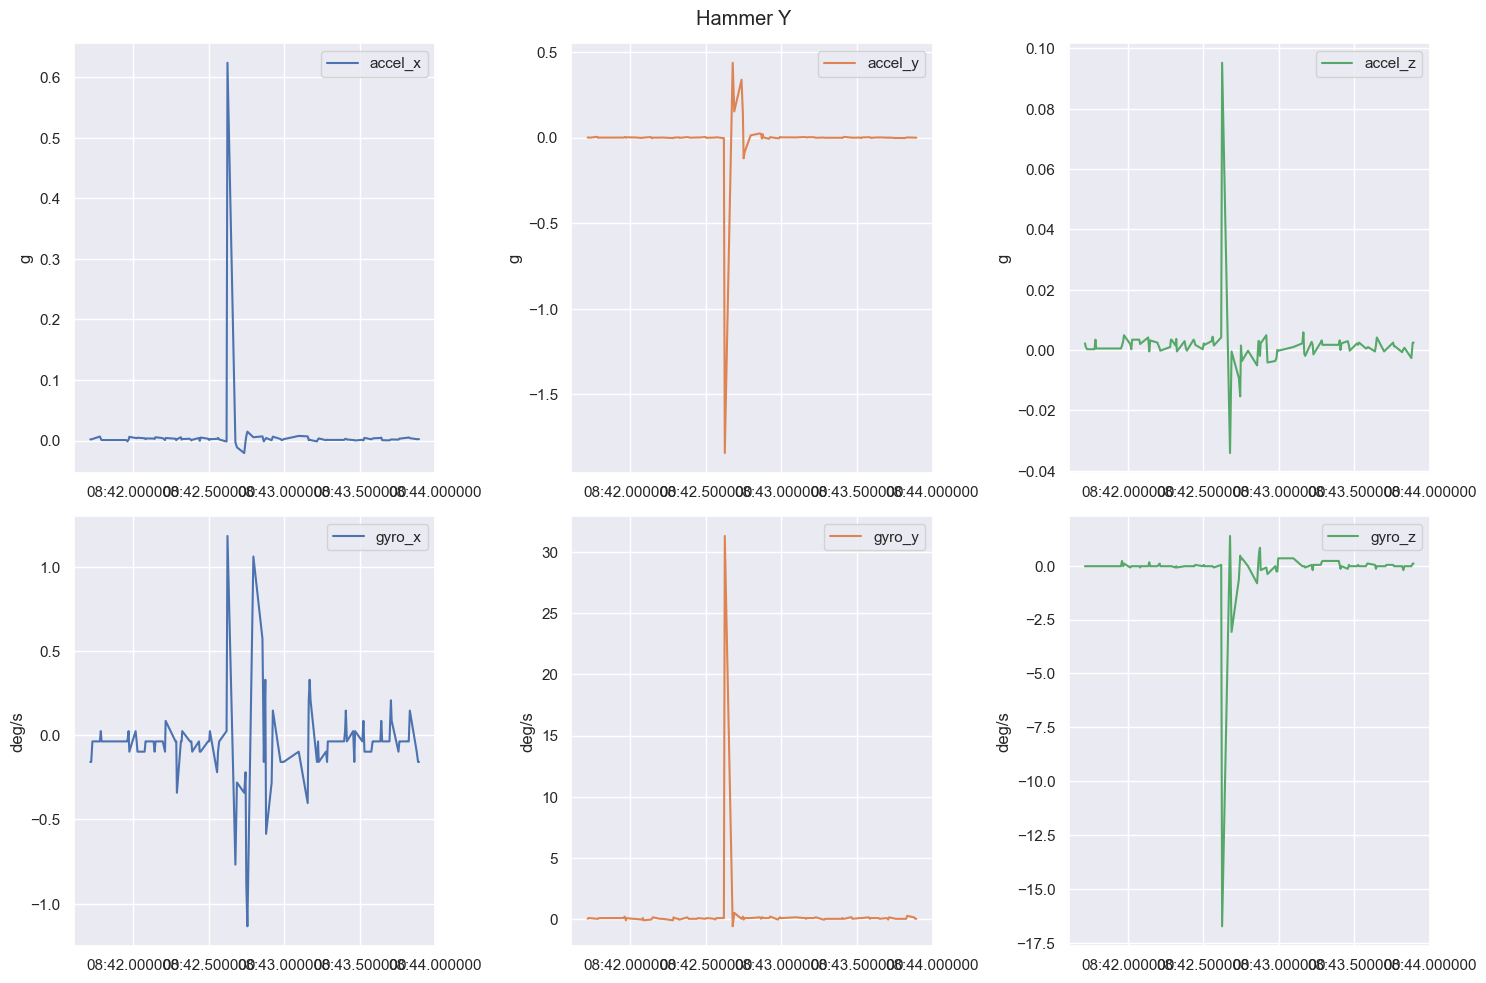

In [56]:
# plot reference data
plot_sensors_df(df_ref, "Reference", x_index='_time')

# plot all the actions

# plot_sensors_df(df_floatingx, "Floating X", x_index='_time')
# plot_sensors_df(df_floatingy, "Floating Y", x_index='_time')
# plot_sensors_df(df_floatingz, "Floating Z", x_index='_time')
plot_sensors_df(df_hammerx, "Hammer X", x_index='_time')
plot_sensors_df(df_hammery, "Hammer Y", x_index='_time')
plot_sensors_df(df_hammerz, "Hammer Z", x_index='_time')
# plot_sensors_df(df_impactx, "Impact X", x_index='_time')
# plot_sensors_df(df_impacty, "Impact Y", x_index='_time')
# plot_sensors_df(df_impactz, "Impact Z", x_index='_time')
# plot_sensors_df(df_rotationx, "Rotation X", x_index='_time')
# plot_sensors_df(df_rotationy, "Rotation Y", x_index='_time')
# plot_sensors_df(df_rotationz, "Rotation Z", x_index='_time')

## Data Manipulation

### Re-sampling

In [160]:
# resample the dataset to 0.01s
sampling_time = 0.01

# keep only columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_x', 'quat_y', 'quat_z', 'quat_w']
df_ref_over = df_ref[columns].copy()
df_floatinx_over = df_floatingx[columns].copy()
df_floatiny_over = df_floatingy[columns].copy()
df_floatinz_over = df_floatingz[columns].copy()
df_hammerx_over = df_hammerx[columns].copy()
df_hammery_over = df_hammery[columns].copy()
df_hammerz_over = df_hammerz[columns].copy()
df_impactx_over = df_impactx[columns].copy()
df_impacty_over = df_impacty[columns].copy()
df_impactz_over = df_impactz[columns].copy()
df_rotationx_over = df_rotationx[columns].copy()
df_rotationy_over = df_rotationy[columns].copy()
df_rotationz_over = df_rotationz[columns].copy()

# resample the dataset
df_ref_over = df_ref_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatinx_over = df_floatinx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatiny_over = df_floatiny_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatinz_over = df_floatinz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammerx_over = df_hammerx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammery_over = df_hammery_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammerz_over = df_hammerz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impactx_over = df_impactx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impacty_over = df_impacty_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impactz_over = df_impactz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationx_over = df_rotationx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationy_over = df_rotationy_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationz_over = df_rotationz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')

# get smallest length
min_window_length = min(len(df_floatinx_over), len(df_floatiny_over), len(df_floatinz_over), len(df_hammerx_over), len(df_hammery_over), len(df_hammerz_over), len(df_impactx_over), len(df_impacty_over), len(df_impactz_over), len(df_rotationx_over), len(df_rotationy_over), len(df_rotationz_over))
max_window_length = max(len(df_floatinx_over), len(df_floatiny_over), len(df_floatinz_over), len(df_hammerx_over), len(df_hammery_over), len(df_hammerz_over), len(df_impactx_over), len(df_impacty_over), len(df_impactz_over), len(df_rotationx_over), len(df_rotationy_over), len(df_rotationz_over))

Calculate magnitude of acceleration and angular velocity

In [161]:
# add a column with the magnitude of the acceleration and gyro
df_ref_over['accel_mag'] = np.sqrt(df_ref_over['accel_x']**2 + df_ref_over['accel_y']**2 + df_ref_over['accel_z']**2)
df_ref_over['gyro_mag'] = np.sqrt(df_ref_over['gyro_x']**2 + df_ref_over['gyro_y']**2 + df_ref_over['gyro_z']**2)
df_floatinx_over['accel_mag'] = np.sqrt(df_floatinx_over['accel_x']**2 + df_floatinx_over['accel_y']**2 + df_floatinx_over['accel_z']**2)
df_floatinx_over['gyro_mag'] = np.sqrt(df_floatinx_over['gyro_x']**2 + df_floatinx_over['gyro_y']**2 + df_floatinx_over['gyro_z']**2)
df_floatiny_over['accel_mag'] = np.sqrt(df_floatiny_over['accel_x']**2 + df_floatiny_over['accel_y']**2 + df_floatiny_over['accel_z']**2)
df_floatiny_over['gyro_mag'] = np.sqrt(df_floatiny_over['gyro_x']**2 + df_floatiny_over['gyro_y']**2 + df_floatiny_over['gyro_z']**2)
df_floatinz_over['accel_mag'] = np.sqrt(df_floatinz_over['accel_x']**2 + df_floatinz_over['accel_y']**2 + df_floatinz_over['accel_z']**2)
df_floatinz_over['gyro_mag'] = np.sqrt(df_floatinz_over['gyro_x']**2 + df_floatinz_over['gyro_y']**2 + df_floatinz_over['gyro_z']**2)
df_hammerx_over['accel_mag'] = np.sqrt(df_hammerx_over['accel_x']**2 + df_hammerx_over['accel_y']**2 + df_hammerx_over['accel_z']**2)
df_hammerx_over['gyro_mag'] = np.sqrt(df_hammerx_over['gyro_x']**2 + df_hammerx_over['gyro_y']**2 + df_hammerx_over['gyro_z']**2)
df_hammery_over['accel_mag'] = np.sqrt(df_hammery_over['accel_x']**2 + df_hammery_over['accel_y']**2 + df_hammery_over['accel_z']**2)
df_hammery_over['gyro_mag'] = np.sqrt(df_hammery_over['gyro_x']**2 + df_hammery_over['gyro_y']**2 + df_hammery_over['gyro_z']**2)
df_hammerz_over['accel_mag'] = np.sqrt(df_hammerz_over['accel_x']**2 + df_hammerz_over['accel_y']**2 + df_hammerz_over['accel_z']**2)
df_hammerz_over['gyro_mag'] = np.sqrt(df_hammerz_over['gyro_x']**2 + df_hammerz_over['gyro_y']**2 + df_hammerz_over['gyro_z']**2)
df_impactx_over['accel_mag'] = np.sqrt(df_impactx_over['accel_x']**2 + df_impactx_over['accel_y']**2 + df_impactx_over['accel_z']**2)
df_impactx_over['gyro_mag'] = np.sqrt(df_impactx_over['gyro_x']**2 + df_impactx_over['gyro_y']**2 + df_impactx_over['gyro_z']**2)
df_impacty_over['accel_mag'] = np.sqrt(df_impacty_over['accel_x']**2 + df_impacty_over['accel_y']**2 + df_impacty_over['accel_z']**2)
df_impacty_over['gyro_mag'] = np.sqrt(df_impacty_over['gyro_x']**2 + df_impacty_over['gyro_y']**2 + df_impacty_over['gyro_z']**2)
df_impactz_over['accel_mag'] = np.sqrt(df_impactz_over['accel_x']**2 + df_impactz_over['accel_y']**2 + df_impactz_over['accel_z']**2)
df_impactz_over['gyro_mag'] = np.sqrt(df_impactz_over['gyro_x']**2 + df_impactz_over['gyro_y']**2 + df_impactz_over['gyro_z']**2)
df_rotationx_over['accel_mag'] = np.sqrt(df_rotationx_over['accel_x']**2 + df_rotationx_over['accel_y']**2 + df_rotationx_over['accel_z']**2)
df_rotationx_over['gyro_mag'] = np.sqrt(df_rotationx_over['gyro_x']**2 + df_rotationx_over['gyro_y']**2 + df_rotationx_over['gyro_z']**2)
df_rotationy_over['accel_mag'] = np.sqrt(df_rotationy_over['accel_x']**2 + df_rotationy_over['accel_y']**2 + df_rotationy_over['accel_z']**2)
df_rotationy_over['gyro_mag'] = np.sqrt(df_rotationy_over['gyro_x']**2 + df_rotationy_over['gyro_y']**2 + df_rotationy_over['gyro_z']**2)
df_rotationz_over['accel_mag'] = np.sqrt(df_rotationz_over['accel_x']**2 + df_rotationz_over['accel_y']**2 + df_rotationz_over['accel_z']**2)
df_rotationz_over['gyro_mag'] = np.sqrt(df_rotationz_over['gyro_x']**2 + df_rotationz_over['gyro_y']**2 + df_rotationz_over['gyro_z']**2)

### Spectrogram

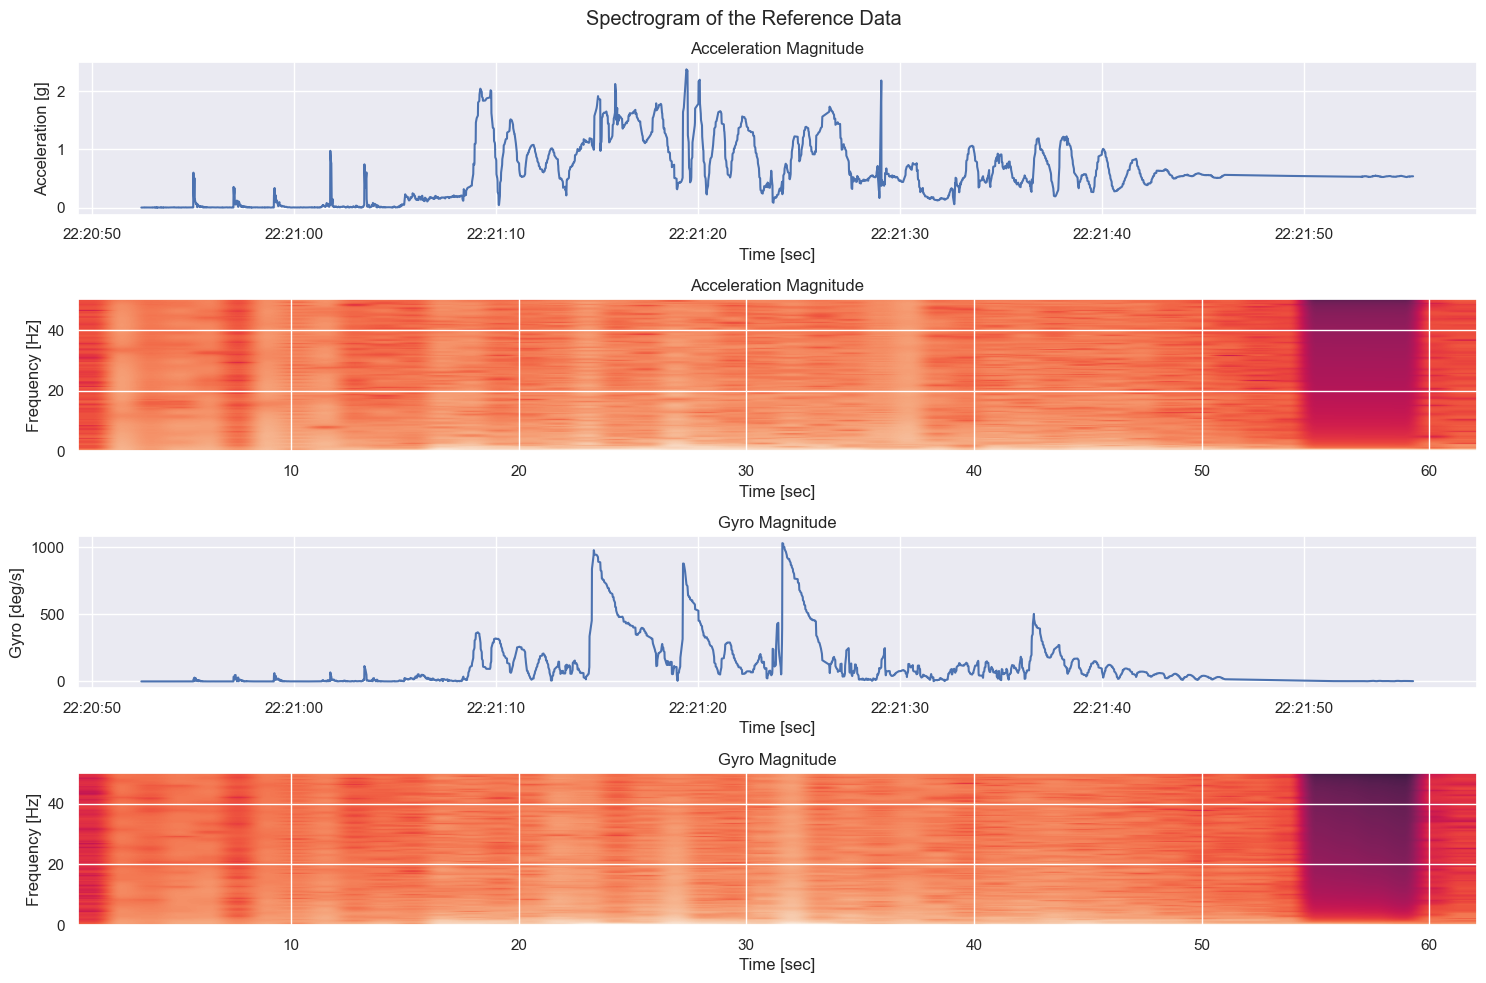

In [162]:
# calculate the spectrogram of the acceleration and gyro
fs = 1/sampling_time
f, t, Sxx_accel = spectrogram(df_ref_over['accel_mag'], fs)
f, t, Sxx_gyro = spectrogram(df_ref_over['gyro_mag'], fs)

# plot the signal, spectrogram of the acceleration and gyro in a 3x1 subplot
fig, axs = plt.subplots(4, 1, figsize=(15, 10))
fig.suptitle('Spectrogram of the Reference Data')

# plot the signal
axs[0].plot(df_ref_over['accel_mag'])
axs[0].set_ylabel('Acceleration [g]')
axs[0].set_xlabel('Time [sec]')
axs[0].set_title('Acceleration Magnitude')

# plot the spectrogram of the acceleration
# im = axs[0].pcolormesh(t, f, Sxx_accel, shading='gouraud')
im = axs[1].specgram(df_ref_over['accel_mag'], Fs=fs)
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Time [sec]')
axs[1].set_title('Acceleration Magnitude')
# fig.colorbar(im, ax=axs[0])

# plot the gyro
axs[2].plot(df_ref_over['gyro_mag'])
axs[2].set_ylabel('Gyro [deg/s]')
axs[2].set_xlabel('Time [sec]')
axs[2].set_title('Gyro Magnitude')

# plot the spectrogram of the gyro
# im = axs[3].pcolormesh(t, f, Sxx_gyro)
im = axs[3].specgram(df_ref_over['gyro_mag'], Fs=fs)
axs[3].set_ylabel('Frequency [Hz]')
axs[3].set_xlabel('Time [sec]')
axs[3].set_title('Gyro Magnitude')
# fig.colorbar(im, ax=axs[1])

# give more space between the subplots
fig.tight_layout(pad=1.0)
plt.show()



### Cross-correlation

In [163]:
# function to caldulate the 1d cross correlation
def crosscorrelation_1d(signal1, signal2, plot=True, title=""):
        
    # calculate the cross correlation
    corr = correlate(signal1, signal2, mode='full')
    # calculate the time lags
    lags = np.arange(1-len(signal1), len(signal2))

    # Find the lag with the maximum correlation
    max_corr_index = np.argmax(corr)
    max_corr_lag = lags[max_corr_index]

    # If max_corr_lag is positive, the second signal leads the reference signal
    if max_corr_lag > 0:
        match_sample_second = max_corr_lag
        match_sample_first = 0
    # If max_corr_lag is negative, the second signal lags the reference signal
    else:
        match_sample_second = 0
        match_sample_first = -max_corr_lag

    if plot:

        # drop _time index
        signal1 = signal1.reset_index(drop=True)
        signal2 = signal2.reset_index(drop=True)
        # Create the subplots
        fig, axs = plt.subplots(3, 1, figsize=(15, 15))  # 3 rows, 1 column

        # Plot the first signal
        axs[0].plot(signal1, label='First Signal', color='C0')
        axs[0].set_title('First Signal - ' + title)
        axs[0].set_xlabel('Samples')
        axs[0].set_ylabel('Magnitude')
        axs[0].grid(True)

        # Plot the second signal
        axs[1].plot(signal2, label='Second Signal - ' + title, color='C0')
        axs[1].set_title('Second Signal - ' + title)
        axs[1].set_xlabel('Samples')
        axs[1].set_ylabel('Magnitude')
        axs[1].grid(True)

        # Mark the points of maximum correlation on both signals
        axs[0].axvline(x=max_corr_index, color='r', linestyle='--', label='Maximum Correlation Lag')
        axs[1].axvline(x=match_sample_second, color='r', linestyle='--', label='Maximum Correlation Lag')

        # Plot the cross-correlation
        axs[2].plot(lags, corr, label='Cross Correlation', color='C1')
        axs[2].set_title('Cross Correlation')
        axs[2].set_xlabel('Lag (Samples)')
        axs[2].set_ylabel('Cross Correlation')
        axs[2].grid(True)
        axs[2].axvline(x=max_corr_lag, color='r', linestyle='--', label='Maximum Correlation Lag')

        # Add legends
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

    return corr, max_corr_lag, max_corr_index
    

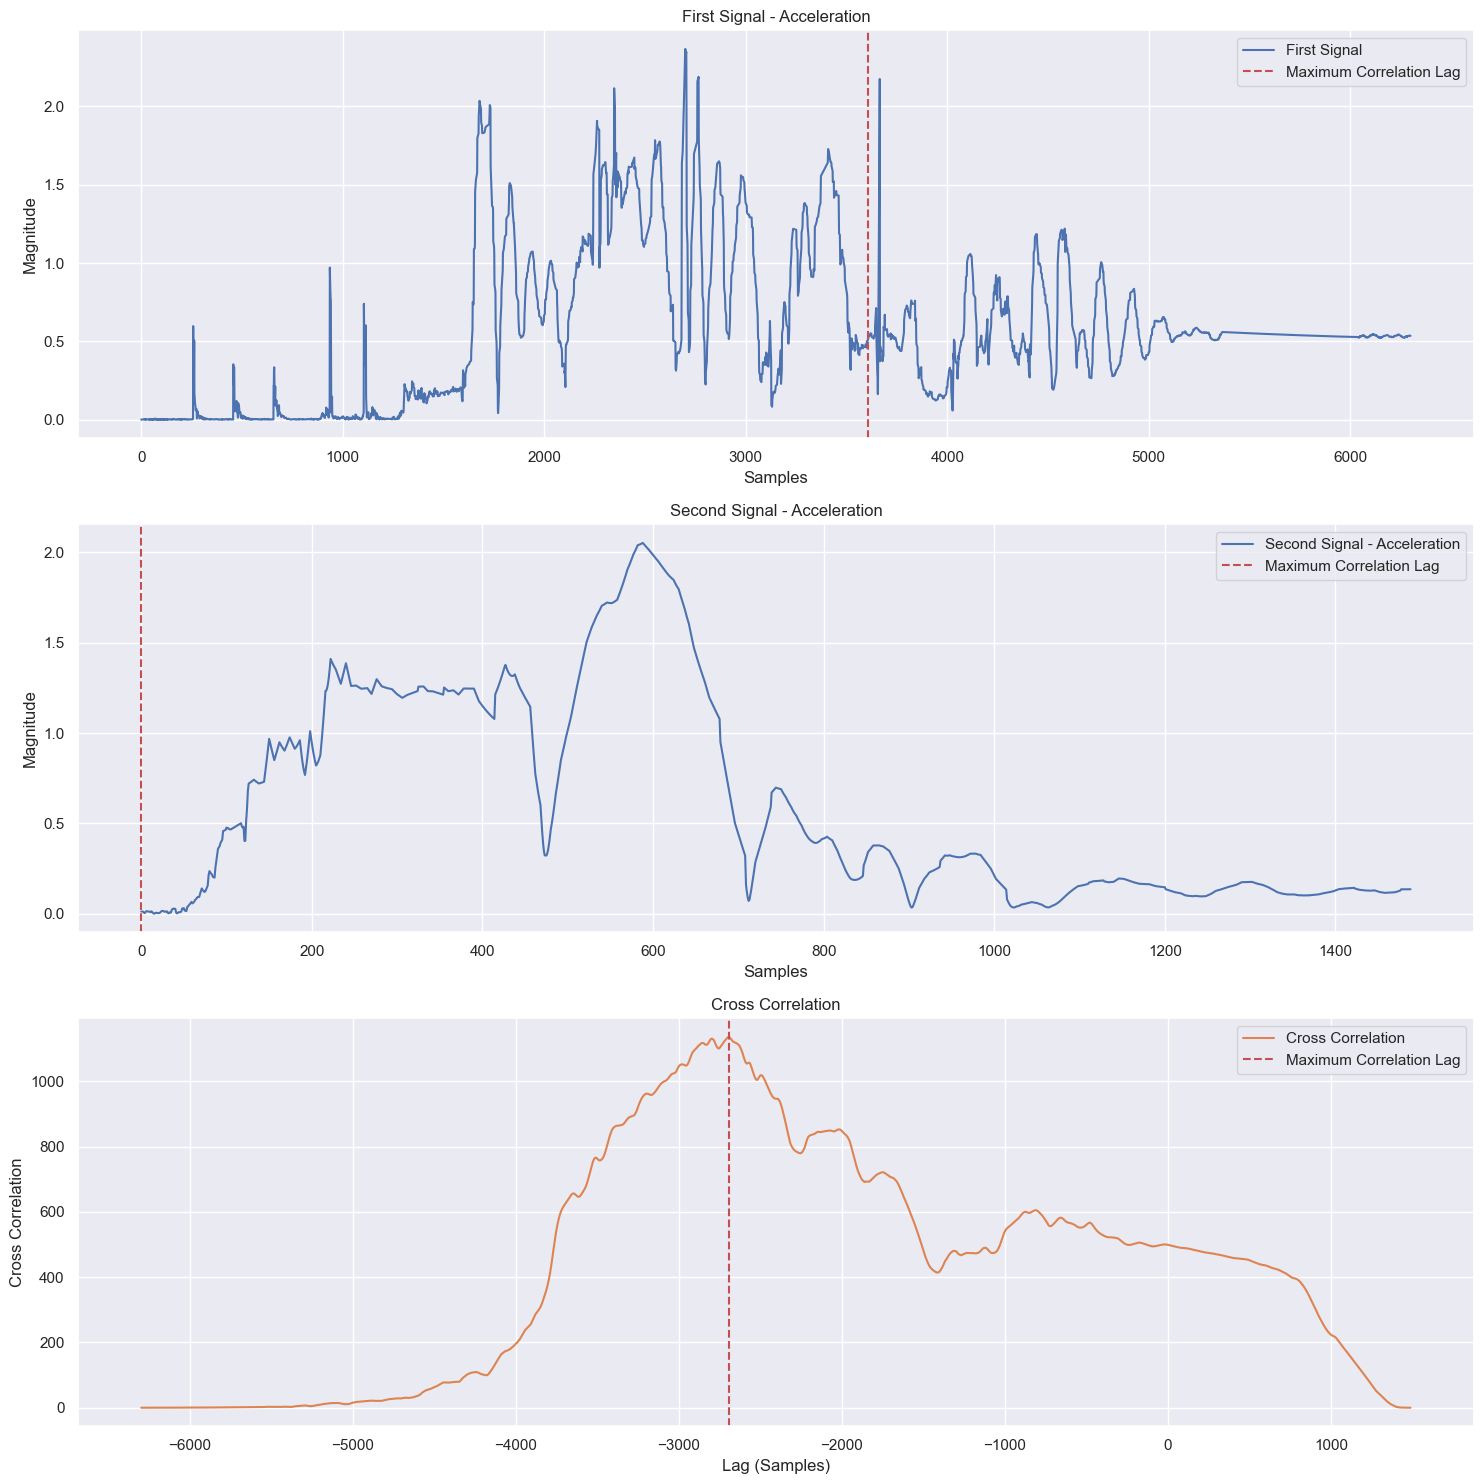

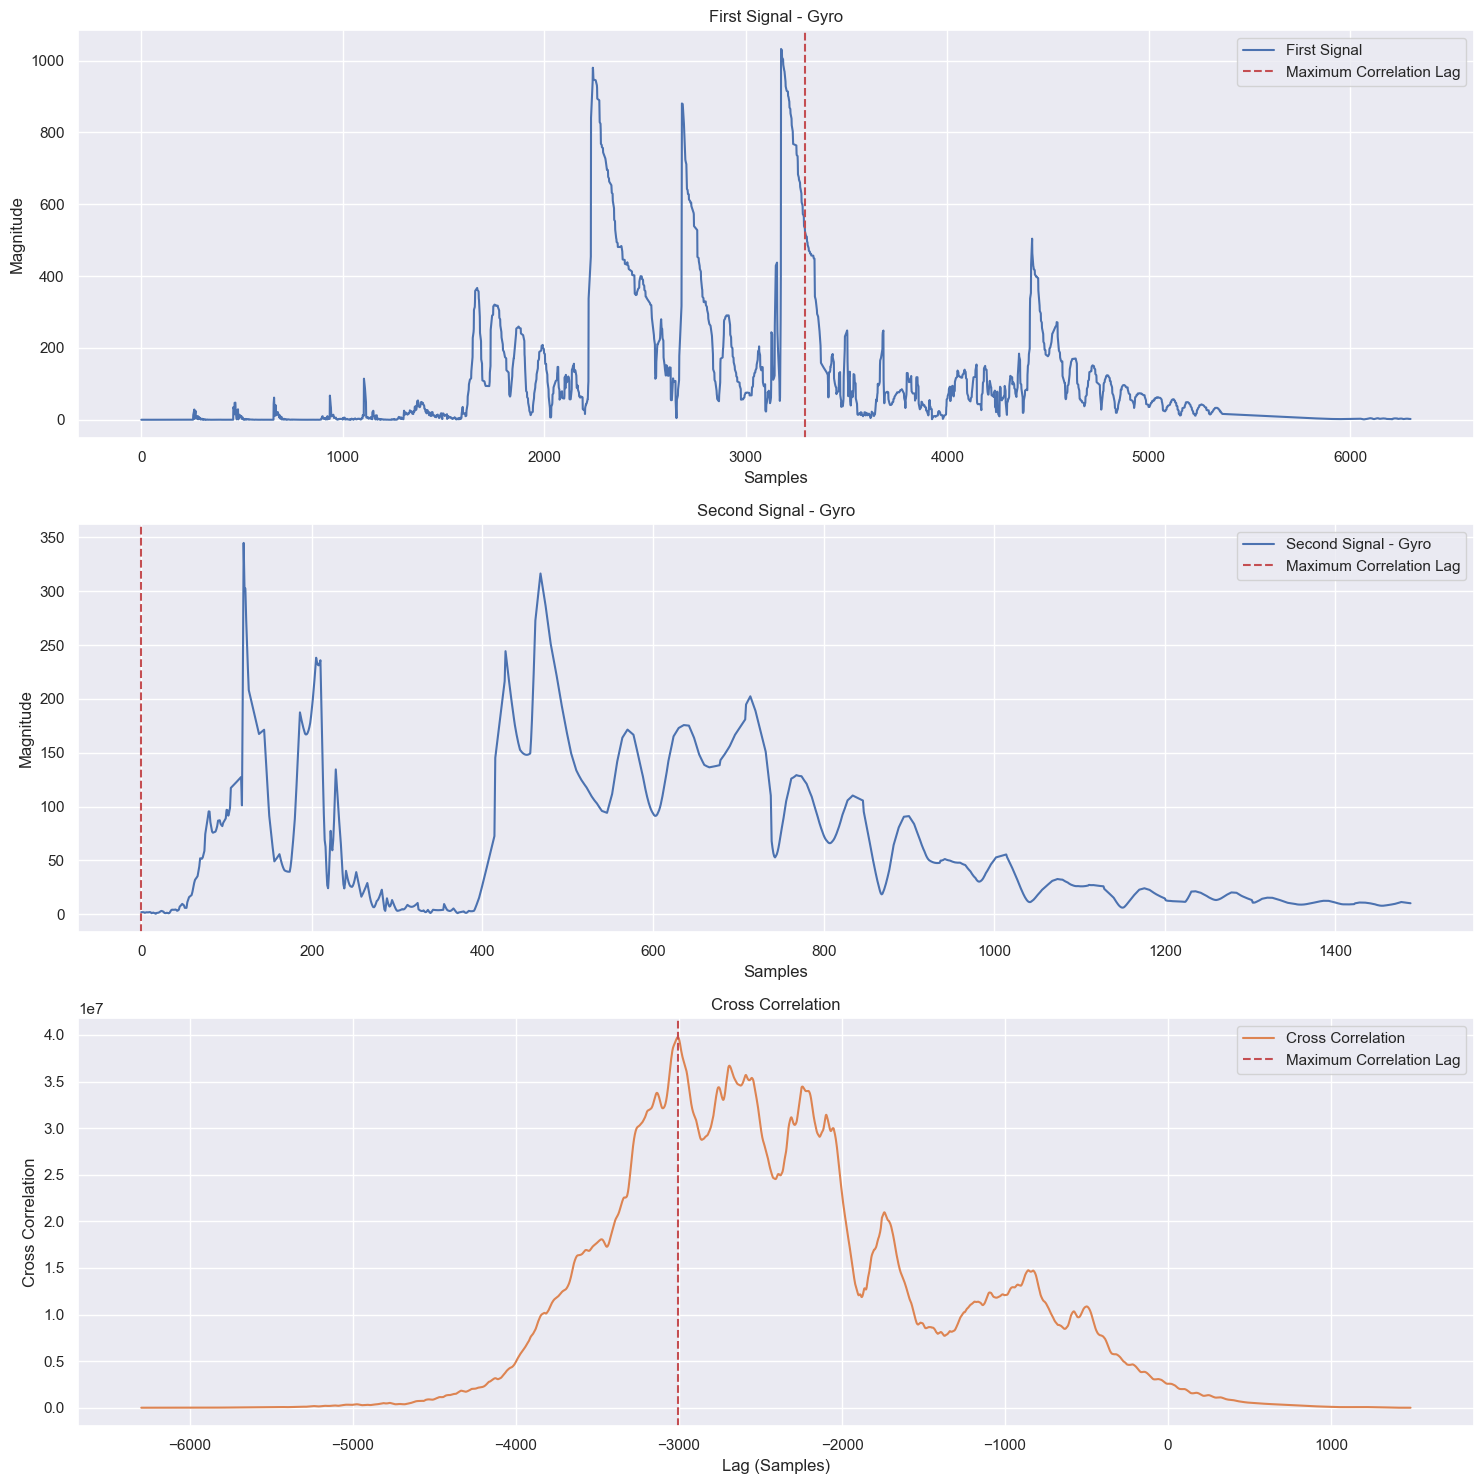

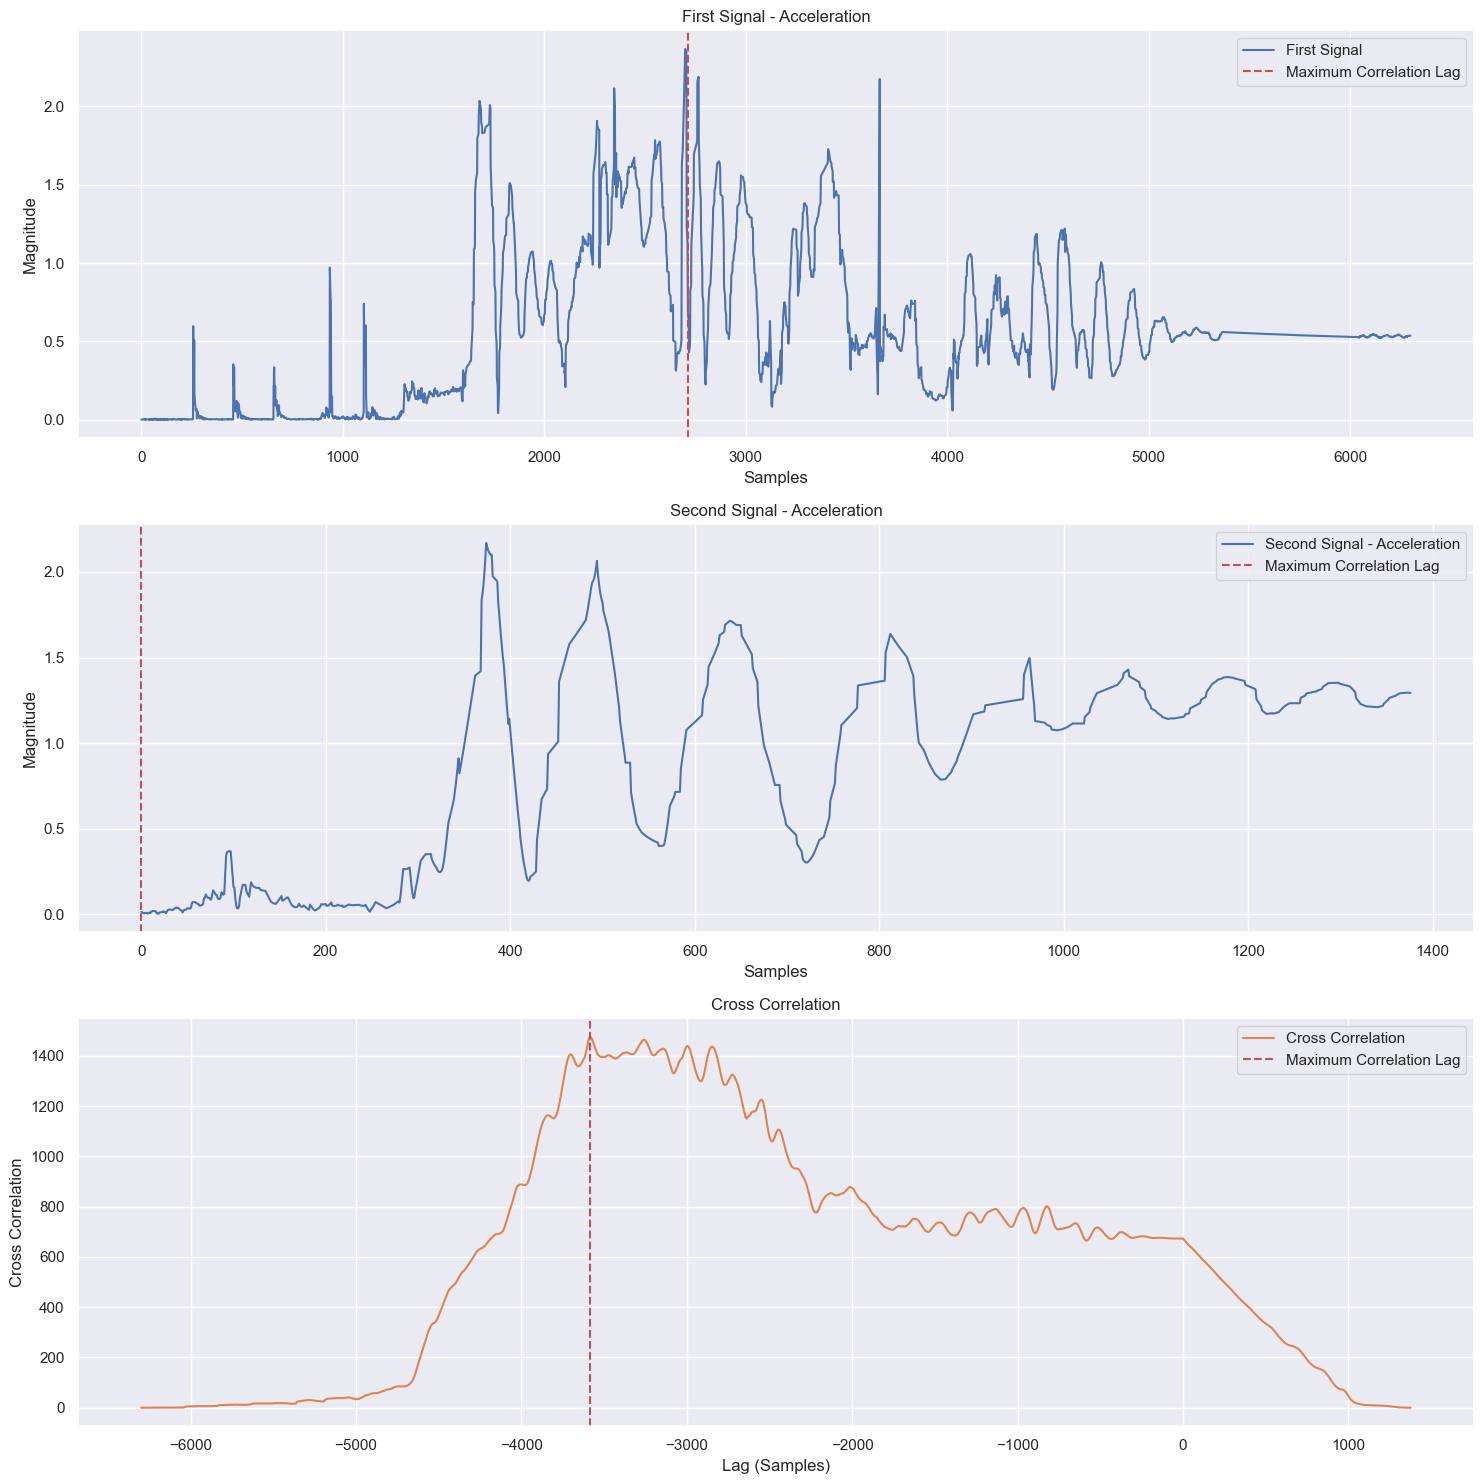

In [164]:
# x axis sequences
corr_ref_float_accel, lag_ref_floatx_accel, max_corr_ref_floatx_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_floatinx_over['accel_mag'], plot=True, title="Acceleration")
corr_ref_float_gyro, lag_ref_floatx_gyro, max_corr_ref_floatx_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_floatinx_over['gyro_mag'], plot=True, title="Gyro")
corr_ref_hammer_accel, lag_ref_hammerx_accel, max_corr_ref_hammerx_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_hammerx_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_hammer_gyro, lag_ref_hammerx_gyro, max_corr_ref_hammerx_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_hammerx_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_impact_accel, lag_ref_impactx_accel, max_corr_ref_impactx_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_impactx_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_impact_gyro, lag_ref_impactx_gyro, max_corr_ref_impactx_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_impactx_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_rotation_accel, lag_ref_rotationx_accel, max_corr_ref_rotationx_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_rotationx_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_rotation_gyro, lag_ref_rotationx_gyro, max_corr_ref_rotationx_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_rotationx_over['gyro_mag'], plot=False, title="Gyro")

# y axis sequences
corr_ref_float_accel, lag_ref_floaty_accel, max_corr_ref_floaty_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_floatiny_over['accel_mag'], plot=True, title="Acceleration")
corr_ref_float_gyro, lag_ref_floaty_gyro, max_corr_ref_floaty_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_floatiny_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_hammer_accel, lag_ref_hammery_accel, max_corr_ref_hammery_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_hammery_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_hammer_gyro, lag_ref_hammery_gyro, max_corr_ref_hammery_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_hammery_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_impact_accel, lag_ref_impacty_accel, max_corr_ref_impacty_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_impacty_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_impact_gyro, lag_ref_impacty_gyro, max_corr_ref_impacty_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_impacty_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_rotation_accel, lag_ref_rotationy_accel, max_corr_ref_rotationy_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_rotationy_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_rotation_gyro, lag_ref_rotationy_gyro, max_corr_ref_rotationy_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_rotationy_over['gyro_mag'], plot=False, title="Gyro")

# z axis sequences
corr_ref_float_accel, lag_ref_floatz_accel, max_corr_ref_floatz_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_floatinz_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_float_gyro, lag_ref_floatz_gyro, max_corr_ref_floatz_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_floatinz_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_hammer_accel, lag_ref_hammerz_accel, max_corr_ref_hammerz_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_hammerz_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_hammer_gyro, lag_ref_hammerz_gyro, max_corr_ref_hammerz_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_hammerz_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_impact_accel, lag_ref_impactz_accel, max_corr_ref_impactz_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_impactz_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_impact_gyro, lag_ref_impactz_gyro, max_corr_ref_impactz_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_impactz_over['gyro_mag'], plot=False, title="Gyro")
corr_ref_rotation_accel, lag_ref_rotationz_accel, max_corr_ref_rotationz_accel = crosscorrelation_1d(df_ref_over['accel_mag'], df_rotationz_over['accel_mag'], plot=False, title="Acceleration")
corr_ref_rotation_gyro, lag_ref_rotationz_gyro, max_corr_ref_rotationz_gyro = crosscorrelation_1d(df_ref_over['gyro_mag'], df_rotationz_over['gyro_mag'], plot=False, title="Gyro")


In [165]:
max_corr_indices_accel = [
    max_corr_ref_floatx_accel, max_corr_ref_floaty_accel, max_corr_ref_floatz_accel,
    max_corr_ref_hammerx_accel, max_corr_ref_hammery_accel, max_corr_ref_hammerz_accel,
    max_corr_ref_impactx_accel, max_corr_ref_impacty_accel, max_corr_ref_impactz_accel,
    max_corr_ref_rotationx_accel, max_corr_ref_rotationy_accel, max_corr_ref_rotationz_accel
]

max_corr_indices_gyro = [
    max_corr_ref_floatx_gyro, max_corr_ref_floaty_gyro, max_corr_ref_floatz_gyro,
    max_corr_ref_hammerx_gyro, max_corr_ref_hammery_gyro, max_corr_ref_hammerz_gyro,
    max_corr_ref_impactx_gyro, max_corr_ref_impacty_gyro, max_corr_ref_impactz_gyro,
    max_corr_ref_rotationx_gyro, max_corr_ref_rotationy_gyro, max_corr_ref_rotationz_gyro
]

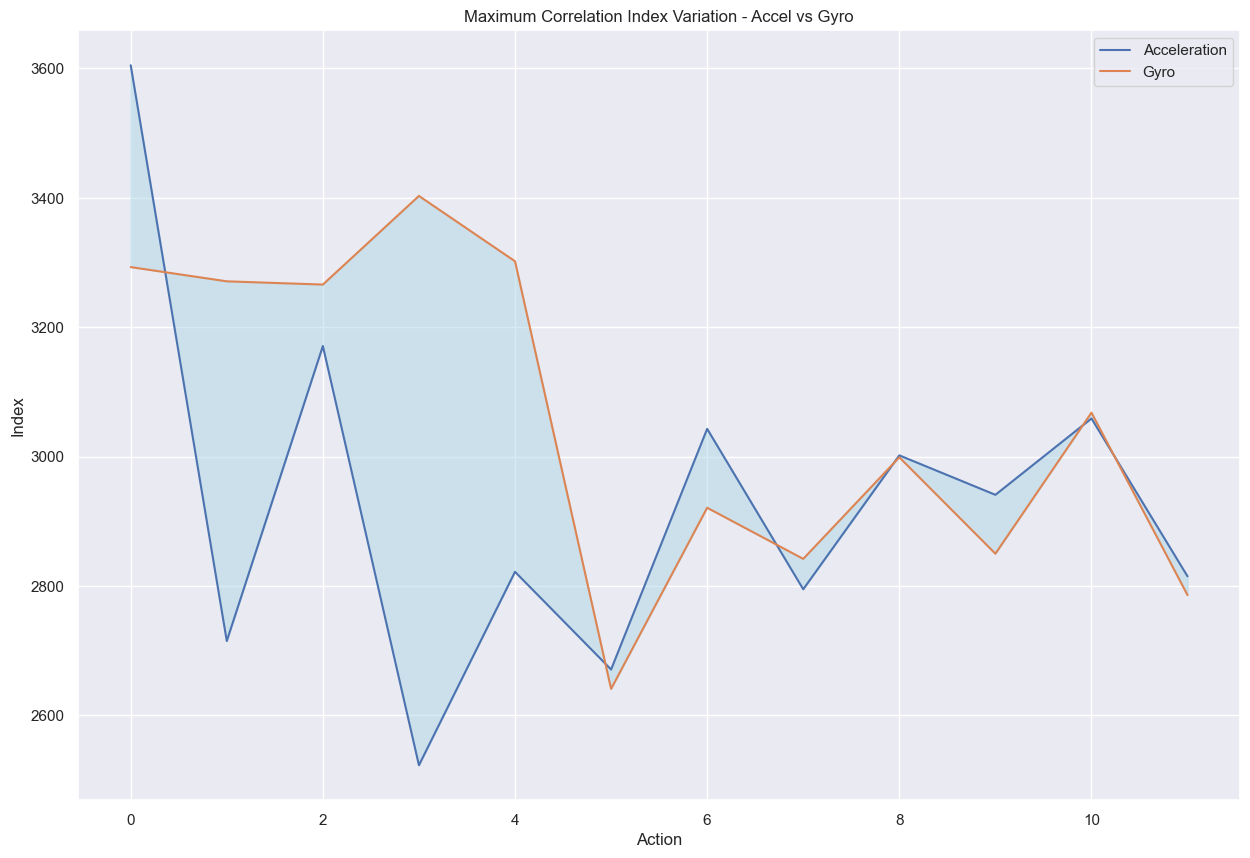

In [166]:
# plot the variation of the maximum correlation index for acceleration and gyro
plt.figure(figsize=(15, 10))
plt.plot(max_corr_indices_accel, label='Acceleration')
plt.plot(max_corr_indices_gyro, label='Gyro')
plt.fill_between(range(len(max_corr_indices_accel)), max_corr_indices_accel, max_corr_indices_gyro, color='lightblue', alpha=0.5)
plt.title('Maximum Correlation Index Variation - Accel vs Gyro')
plt.xlabel('Action')
plt.ylabel('Index')
plt.legend()
plt.grid(True)
plt.show()


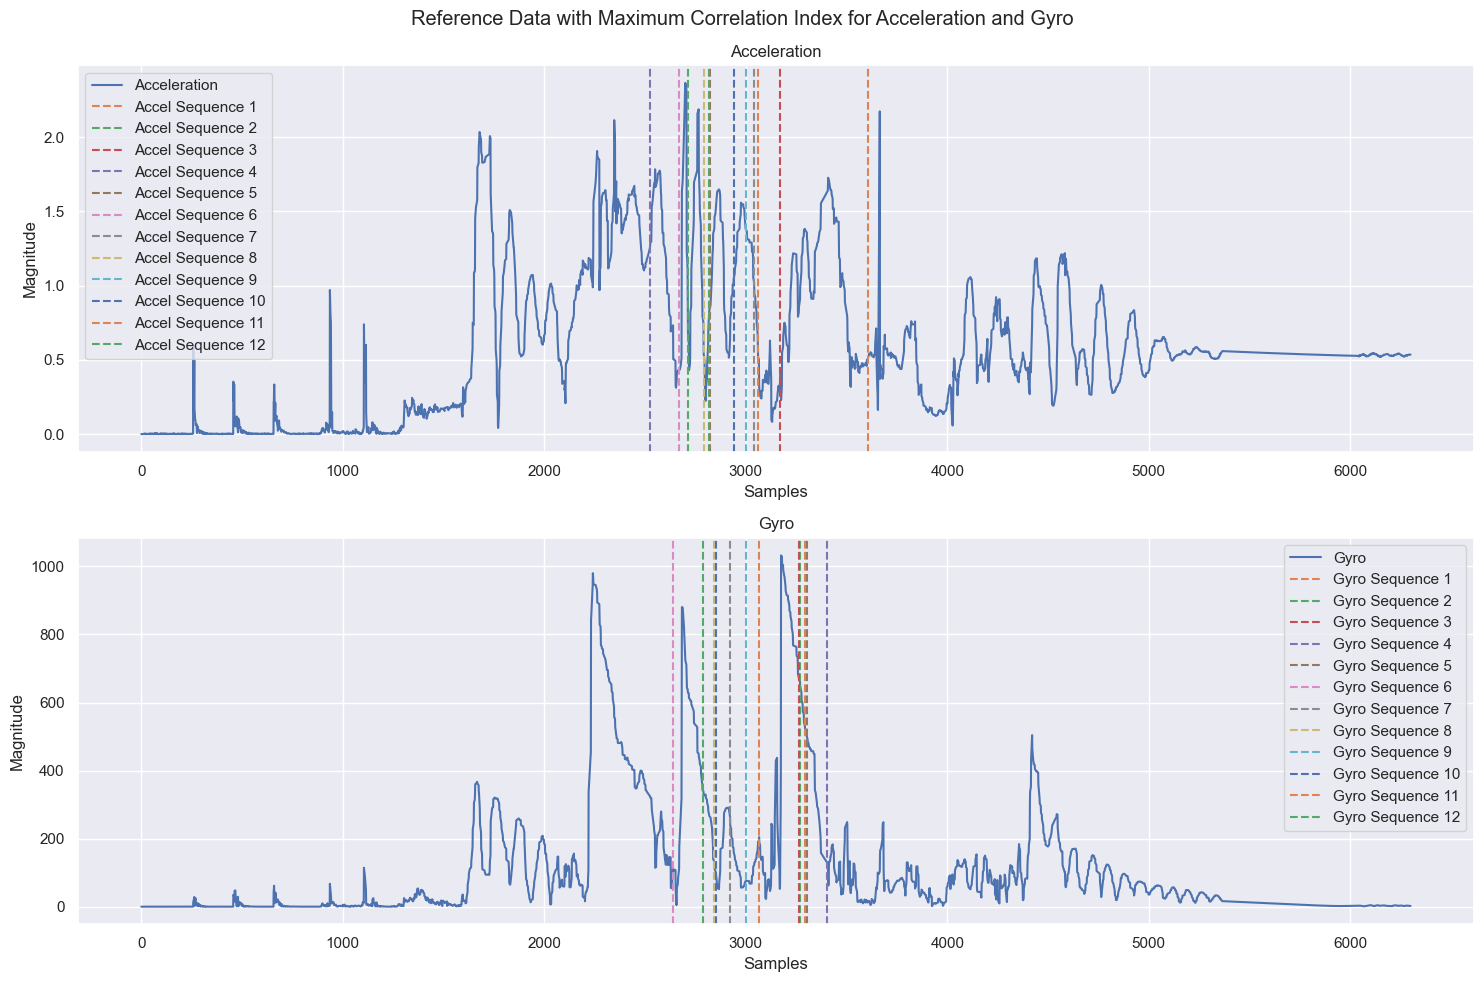

In [167]:
# plot the reference data with the maximum correlation index for acceleration and gyro for all the actions
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Reference Data with Maximum Correlation Index for Acceleration and Gyro')

signal = df_ref_over.copy()
signal = signal.reset_index(drop=True)

# plot the reference data with the maximum correlation index for acceleration
axs[0].plot(signal['accel_mag'], label='Acceleration')
axs[0].set_title('Acceleration')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Magnitude')
axs[0].grid(True)
for i in range(0, len(max_corr_indices_accel)):
    axs[0].axvline(x=max_corr_indices_accel[i], color=f'C{i+1}', linestyle='--', label=f'Accel Sequence {i+1}')

# plot the reference data with the maximum correlation index for gyro
axs[1].plot(signal['gyro_mag'], label='Gyro')
axs[1].set_title('Gyro')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Magnitude')

axs[1].grid(True)
for i in range(0, len(max_corr_indices_gyro)):
    axs[1].axvline(x=max_corr_indices_gyro[i], color=f'C{i+1}', linestyle='--', label=f'Gyro Sequence {i+1}')
# Add legends
axs[0].legend()
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

### FFT

##### Functions

In [188]:
def get_fft_peaks(df, sampling_time, title="", plot=False, window=0, shift=0):
    """Get the fft peaks of the dataframe

    Args:
        df (): pandas dataframe
        sampling_time (float): sampling time
        title (str, optional): title of the plot. Defaults to "".
        plot (bool, optional): plot the fft. Defaults to False.
        window (int, optional): number of samples to split the dataframe and calculate the fft on each window. Defaults to 0.
        shift (int, optional): number of samples to shift the window and recalculate the fft. Defaults to 0.

    Returns:
        data_struct: struct with fft values, frequency and peaks
    """
    
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    num_peaks = 5
    order_peaks = 8
    
    df_window = []
    index_window_pairs = []  # Initialize a list to store index-window pairs

    if window > 0:
        # get a new index before resampling
        df = df.reset_index(drop=True)

        # split the dataframe in windows of size window, every new window is shifted by shift from the last sample of the previous window
        for i in range(0, len(df), shift):
            # if the size of the window is less than window, add 0 paddings
            if i+window > len(df):
                diff = i+window - len(df)
                padded_window = df[i:].copy()
                padded_window = padded_window.reindex(range(diff), fill_value=0.0)
                # start the index from the last sample of the previous window
                last_index = df[i:].index[-1]
                padded_window.index = range(last_index+1, last_index+1+diff)
                # add the padded window to the list
                padded_window = pd.concat([df[i:], padded_window])
                
                # add the window to the list
                df_window.append(padded_window)
            else:
                # add the window to the list
                df_window.append(df[i:i+window])
            
            window_end = min(i + window, len(df))
            current_window = df[i:window_end]

            # Generate index-window pairs for the current window
            for idx in current_window.index:
                index_window_pairs.append([idx, i // shift])  # Divide by shift to get sequential window numbers
    else:
        df_window.append(df)
        for idx in df.index:
            index_window_pairs.append([idx, 0])  # If no windowing, all samples belong to window 0

    # Initialize a dictionary to aggregate window IDs by index
    index_to_windows = {}

    # Aggregate window IDs for each index
    for idx, window_id in index_window_pairs:
        if idx not in index_to_windows:
            index_to_windows[idx] = set()
        index_to_windows[idx].add(window_id)

    # Convert the dictionary to the desired list format
    index_windows_list = [list(window_ids) for idx, window_ids in index_to_windows.items()]
    
    # print("Number of windows: ", len(df_window))
    # print(df_window)     

    # create struct to return
    data_struct = {}

    for i in range(len(df_window)):
        # add a new key to the struct
        data_struct[i] = {}

    if plot:
        fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
        fig.suptitle("FFT with peaks " + title)
    
    for i, df in enumerate(df_window):
        # print("Window: ", i)
        # print(df)
        # variable to store the accel and gyro peak values
        accel_peak_values = []
        gyro_peak_values = []
        # variable to store the accel and gyro peak frequencies
        accel_peak_freq = []
        gyro_peak_freq = []

        for j, column in enumerate(columns):
            # get the fft
            fft_values = fft(df[column].values)
            # get the frequency
            freq = fftfreq(len(df[column].values), d=sampling_time)
            # get the peaks
            peaks = argrelmax(np.abs(fft_values[freq>=0]), order=order_peaks)[0]
            while len(peaks) < num_peaks and order_peaks > 1:
                # reduce the order
                order_peaks = order_peaks - 1
                # get the peaks
                peaks = argrelmax(np.abs(fft_values[freq>=0]), order=order_peaks)[0]
            
            # take the top 5 peaks which are greater than 0
            peaks = peaks[np.argsort(np.abs(fft_values[freq>=0][peaks]))[-5:]]
            # sort the peaks
            peaks.sort()
            # update the struct
            data_struct[i][column] = {'fft_values': fft_values, 'freq': freq, 'peaks': peaks}

            # add the peaks to the list
            if 'accel' in column:
                accel_peak_values.append(np.abs(fft_values[freq>=0][peaks]))
                accel_peak_freq.append(freq[peaks])
            else:
                gyro_peak_values.append(np.abs(fft_values[freq>=0][peaks]))
                gyro_peak_freq.append(freq[peaks])

            if plot:
                # plot the fft
                axs[j//3, j%3].plot(freq[freq>=0], np.abs(fft_values[freq>=0]), color='C'+str(j%3), label=column)
                # plot the peaks
                axs[j//3, j%3].plot(freq[peaks], np.abs(fft_values[freq>=0][peaks]), 'x', color='red', label='peaks')
                if window == 0:
                    axs[j//3, j%3].legend()

                # set the y label
                if 'accel' in column:
                    axs[j//3, j%3].set_ylabel('g')
                else:
                    axs[j//3, j%3].set_ylabel('deg/s')
        
        # concatenate the peaks
        accel_peak_values = np.concatenate(accel_peak_values)
        gyro_peak_values = np.concatenate(gyro_peak_values)
        accel_peak_freq = np.concatenate(accel_peak_freq)
        gyro_peak_freq = np.concatenate(gyro_peak_freq)
        # check if there are duplicated frequencies and remove them together with the values
        accel_peak_freq, index = np.unique(accel_peak_freq, return_index=True)
        accel_peak_values = accel_peak_values[index]
        gyro_peak_freq, index = np.unique(gyro_peak_freq, return_index=True)
        gyro_peak_values = gyro_peak_values[index]
        # sort the peaks
        accel_peak_values = accel_peak_values[np.argsort(accel_peak_freq)]
        gyro_peak_values = gyro_peak_values[np.argsort(gyro_peak_freq)]
        accel_peak_freq = accel_peak_freq[np.argsort(accel_peak_freq)]
        gyro_peak_freq = gyro_peak_freq[np.argsort(gyro_peak_freq)]

        # add the peaks to the struct
        data_struct[i]['accel_peaks'] = accel_peak_values
        data_struct[i]['accel_peaks_freq'] = accel_peak_freq
        data_struct[i]['gyro_peaks'] = gyro_peak_values
        data_struct[i]['gyro_peaks_freq'] = gyro_peak_freq

    if window > 0:
        return data_struct, index_windows_list
    else:
        return data_struct

In [169]:
def plot_stem_peaks(sensor_fft, title=""):

    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle("FFT Peaks - "+title)

    for i, column in enumerate(columns):
        # stem plot
        axs[i//3, i%3].stem(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, basefmt='C'+str(i%3), linefmt='C'+str(i%3))
        axs[i//3, i%3].plot(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, color='C'+str(i%3), alpha=0.5)
        
        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')
            axs[i//3, i%3].set_xlabel('Hz')

        axs[i//3, i%3].legend()


    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

In [170]:
def plot_peaks_combined(sensor_struct, title=""):

    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle("FFT Peaks - "+title)

    axs[0].stem(sensor_struct['accel_peaks_freq'], sensor_struct['accel_peaks'], label='accel_xyz', basefmt='C0', linefmt='C0')
    axs[0].plot(sensor_struct['accel_peaks_freq'], sensor_struct['accel_peaks'], label='accel_xyz', color='C0', alpha=0.5)
    axs[1].stem(sensor_struct['gyro_peaks_freq'], sensor_struct['gyro_peaks'], label='gyro_xyz', basefmt='C1', linefmt='C1')
    axs[1].plot(sensor_struct['gyro_peaks_freq'], sensor_struct['gyro_peaks'], label='gyro_xyz', color='C1', alpha=0.5)

    axs[0].set_ylabel('g')
    axs[1].set_ylabel('deg/s')
    axs[1].set_xlabel('Hz')

    axs[0].legend()
    axs[1].legend()
    
    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

In [171]:
# zip peaks and frequencies
def zip_peaks_freq(freq, peaks):
    return np.array(list(zip(freq, peaks)))

##### Code

In [172]:
df_ref_over

accel_x   accel_y   accel_z    gyro_x    gyro_y  \
_time                                                                       
2024-01-14 22:20:52.420 -0.000098  0.000391  0.001050  0.042683 -0.036585   
2024-01-14 22:20:52.430  0.000065  0.000228  0.000724  0.052846 -0.026423   
2024-01-14 22:20:52.440  0.000228  0.000065  0.000399  0.063008 -0.016260   
2024-01-14 22:20:52.450  0.000391 -0.000098  0.000073  0.073171 -0.006098   
2024-01-14 22:20:52.460  0.000553 -0.000260 -0.000252  0.083333  0.004065   
...                           ...       ...       ...       ...       ...   
2024-01-14 22:21:55.370 -0.003271 -0.324512  0.427466  0.042683 -0.414634   
2024-01-14 22:21:55.380 -0.002783 -0.324219  0.427368  0.103659 -0.365854   
2024-01-14 22:21:55.390 -0.002295 -0.323926  0.427271  0.164634 -0.317073   
2024-01-14 22:21:55.400 -0.001807 -0.323633  0.427173  0.225610 -0.268293   
2024-01-14 22:21:55.410 -0.001318 -0.323340  0.427075  0.286585 -0.219512   

                           gyro_z  quat_x  quat_y  quat_z  quat_w  accel_mag  \
_time                                                                          
2024-01-14 22:20:52.420  0.012195    0.41   -0.38   -0.62    0.55   0.001124   
2024-01-14 22:20:52.430  0.022358    0.41   -0.38   -0.62    0.55   0.000762   
2024-01-14 22:20:52.440  0.032520    0.41   -0.38   -0.62    0.55   0.000464   
2024-01-14 22:20:52.450  0.042683    0.41   -0.38   -0.62    0.55   0.000409   
2024-01-14 22:20:52.460  0.052846    0.41   -0.38   -0.62    0.55   0.000662   
...                           ...     ...     ...     ...     ...        ...   
2024-01-14 22:21:55.370  2.207317    0.31   -0.03   -0.22    0.92   0.536699   
2024-01-14 22:21:55.380  2.207317    0.31   -0.03   -0.22    0.92   0.536441   
2024-01-14 22:21:55.390  2.207317    0.31   -0.03   -0.22    0.92   0.536184   
2024-01-14 22:21:55.400  2.207317    0.31   -0.03   -0.22    0.92   0.535927   
2024-01-14 22:21:55.410  2.207317    0.31   -0.03   -0.22    0.92   0.535671   

                         gyro_mag  
_time                              
2024-01-14 22:20:52.420  0.057524  
2024-01-14 22:20:52.430  0.063172  
2024-01-14 22:20:52.440  0.072746  
2024-01-14 22:20:52.450  0.084929  
2024-01-14 22:20:52.460  0.098760  
...                           ...  
2024-01-14 22:21:55.370  2.246329  
2024-01-14 22:21:55.380  2.239831  
2024-01-14 22:21:55.390  2.236043  
2024-01-14 22:21:55.400  2.234979  
2024-01-14 22:21:55.410  2.236642  

[6300 rows x 12 columns]

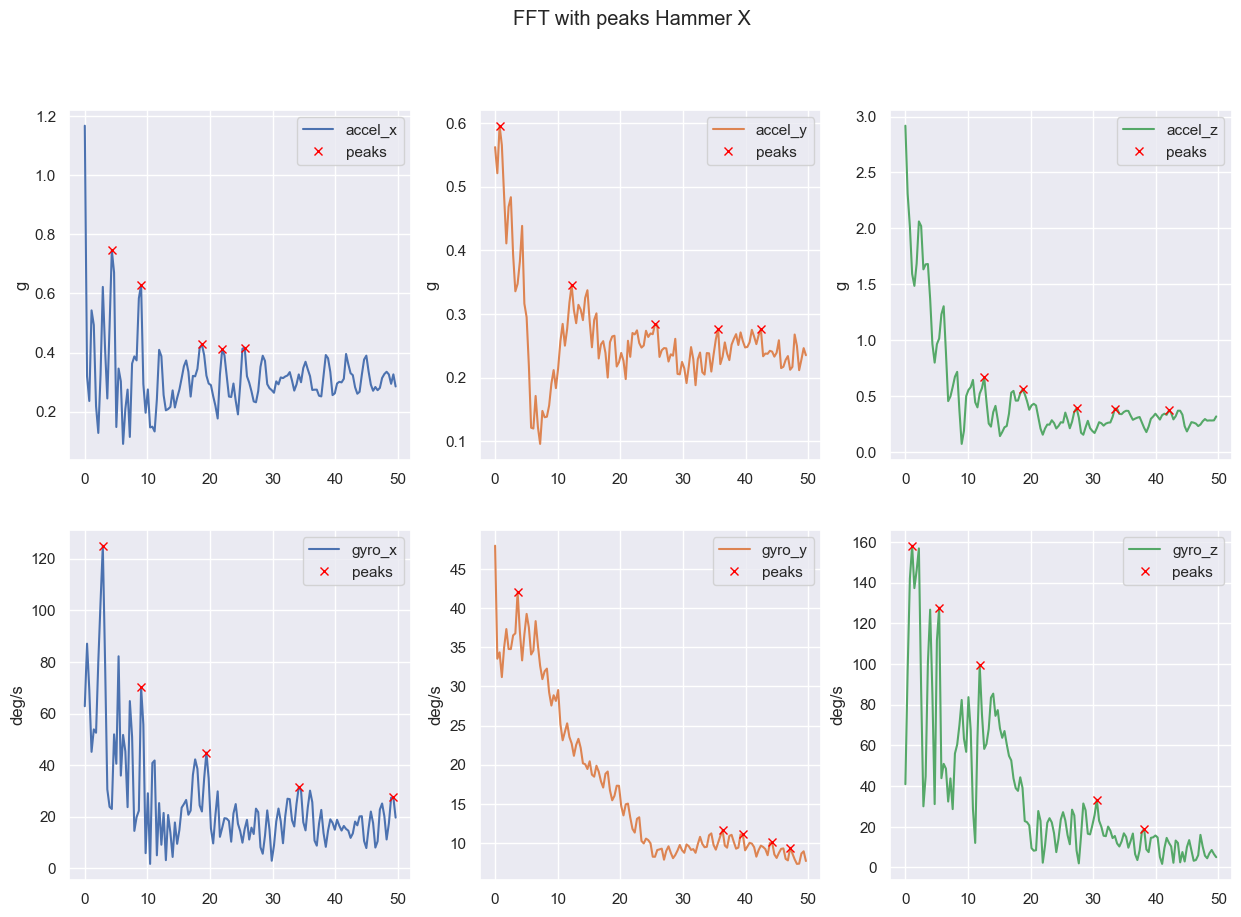

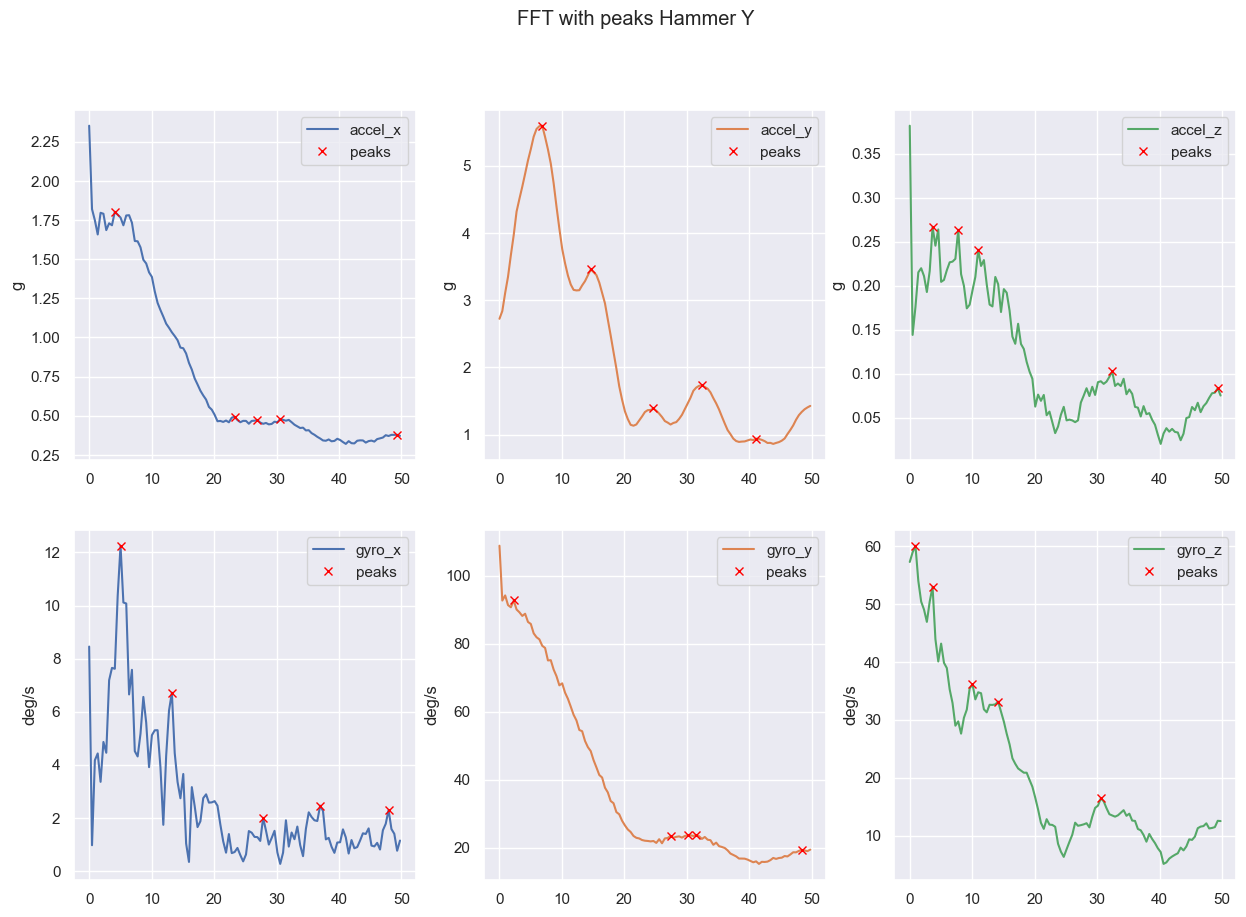

In [189]:
ref_fft, window_ids_list = get_fft_peaks(df_ref_over, sampling_time, title="Reference", plot=False, window=min_window_length, shift=min_window_length//2)
floatingx_fft = get_fft_peaks(df_floatinx_over, sampling_time, title="Floating X", plot=False)
floatingy_fft = get_fft_peaks(df_floatiny_over, sampling_time, title="Floating Y", plot=False)
floatingz_fft = get_fft_peaks(df_floatinz_over, sampling_time, title="Floating Z", plot=False)
hammerx_fft = get_fft_peaks(df_hammerx_over, sampling_time, title="Hammer X", plot=True)
hammery_fft = get_fft_peaks(df_hammery_over, sampling_time, title="Hammer Y", plot=True)
hammerz_fft = get_fft_peaks(df_hammerz_over, sampling_time, title="Hammer Z", plot=True)
impactx_fft = get_fft_peaks(df_impactx_over, sampling_time, title="Impact X", plot=False)
impacty_fft = get_fft_peaks(df_impacty_over, sampling_time, title="Impact Y", plot=False)
impactz_fft = get_fft_peaks(df_impactz_over, sampling_time, title="Impact Z", plot=False)
rotationx_fft = get_fft_peaks(df_rotationx_over, sampling_time, title="Rotation X", plot=False)
rotationy_fft = get_fft_peaks(df_rotationy_over, sampling_time, title="Rotation Y", plot=False)
rotationz_fft = get_fft_peaks(df_rotationz_over, sampling_time, title="Rotation Z", plot=False)

In [190]:
# append the window ids to the reference dataframe
df_ref_over['window_id'] = window_ids_list

In [191]:
df_ref_over

accel_x   accel_y   accel_z    gyro_x    gyro_y  \
_time                                                                       
2024-01-14 22:20:52.420 -0.000098  0.000391  0.001050  0.042683 -0.036585   
2024-01-14 22:20:52.430  0.000065  0.000228  0.000724  0.052846 -0.026423   
2024-01-14 22:20:52.440  0.000228  0.000065  0.000399  0.063008 -0.016260   
2024-01-14 22:20:52.450  0.000391 -0.000098  0.000073  0.073171 -0.006098   
2024-01-14 22:20:52.460  0.000553 -0.000260 -0.000252  0.083333  0.004065   
...                           ...       ...       ...       ...       ...   
2024-01-14 22:21:55.370 -0.003271 -0.324512  0.427466  0.042683 -0.414634   
2024-01-14 22:21:55.380 -0.002783 -0.324219  0.427368  0.103659 -0.365854   
2024-01-14 22:21:55.390 -0.002295 -0.323926  0.427271  0.164634 -0.317073   
2024-01-14 22:21:55.400 -0.001807 -0.323633  0.427173  0.225610 -0.268293   
2024-01-14 22:21:55.410 -0.001318 -0.323340  0.427075  0.286585 -0.219512   

                           gyro_z  quat_x  quat_y  quat_z  quat_w  accel_mag  \
_time                                                                          
2024-01-14 22:20:52.420  0.012195    0.41   -0.38   -0.62    0.55   0.001124   
2024-01-14 22:20:52.430  0.022358    0.41   -0.38   -0.62    0.55   0.000762   
2024-01-14 22:20:52.440  0.032520    0.41   -0.38   -0.62    0.55   0.000464   
2024-01-14 22:20:52.450  0.042683    0.41   -0.38   -0.62    0.55   0.000409   
2024-01-14 22:20:52.460  0.052846    0.41   -0.38   -0.62    0.55   0.000662   
...                           ...     ...     ...     ...     ...        ...   
2024-01-14 22:21:55.370  2.207317    0.31   -0.03   -0.22    0.92   0.536699   
2024-01-14 22:21:55.380  2.207317    0.31   -0.03   -0.22    0.92   0.536441   
2024-01-14 22:21:55.390  2.207317    0.31   -0.03   -0.22    0.92   0.536184   
2024-01-14 22:21:55.400  2.207317    0.31   -0.03   -0.22    0.92   0.535927   
2024-01-14 22:21:55.410  2.207317    0.31   -0.03   -0.22    0.92   0.535671   

                         gyro_mag window_id  
_time                                        
2024-01-14 22:20:52.420  0.057524       [0]  
2024-01-14 22:20:52.430  0.063172       [0]  
2024-01-14 22:20:52.440  0.072746       [0]  
2024-01-14 22:20:52.450  0.084929       [0]  
2024-01-14 22:20:52.460  0.098760       [0]  
...                           ...       ...  
2024-01-14 22:21:55.370  2.246329  [56, 57]  
2024-01-14 22:21:55.380  2.239831  [56, 57]  
2024-01-14 22:21:55.390  2.236043  [56, 57]  
2024-01-14 22:21:55.400  2.234979  [56, 57]  
2024-01-14 22:21:55.410  2.236642  [56, 57]  

[6300 rows x 13 columns]

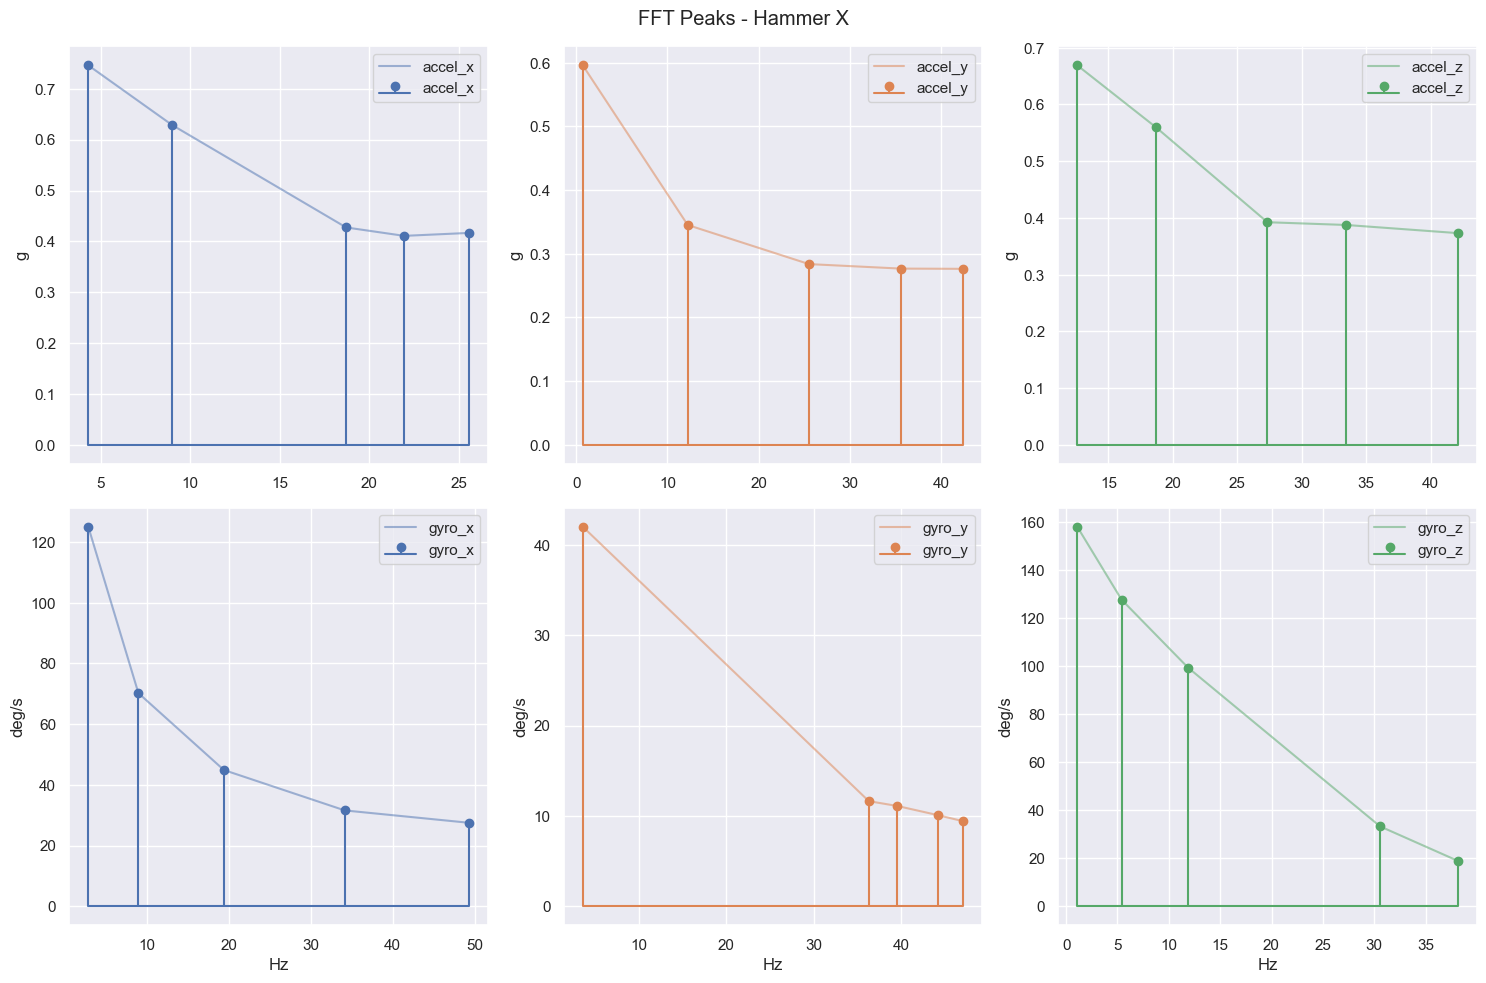

In [193]:
# plot_stem_peaks(ref_fft[100], title="Reference")
# plot_stem_peaks(floatingx_fft, title="Floating X")
# plot_stem_peaks(floatingy_fft, title="Floating Y")
# plot_stem_peaks(floatingz_fft, title="Floating Z")
plot_stem_peaks(hammerx_fft[0], title="Hammer X")
# plot_stem_peaks(hammery_fft[0], title="Hammer Y")
# plot_stem_peaks(hammerz_fft[0], title="Hammer Z")
# plot_stem_peaks(impactx_fft, title="Impact X")
# plot_stem_peaks(impacty_fft, title="Impact Y")
# plot_stem_peaks(impactz_fft, title="Impact Z")
# plot_stem_peaks(rotationx_fft, title="Rotation X")
# plot_stem_peaks(rotationy_fft, title="Rotation Y")
# plot_stem_peaks(rotationz_fft, title="Rotation Z")

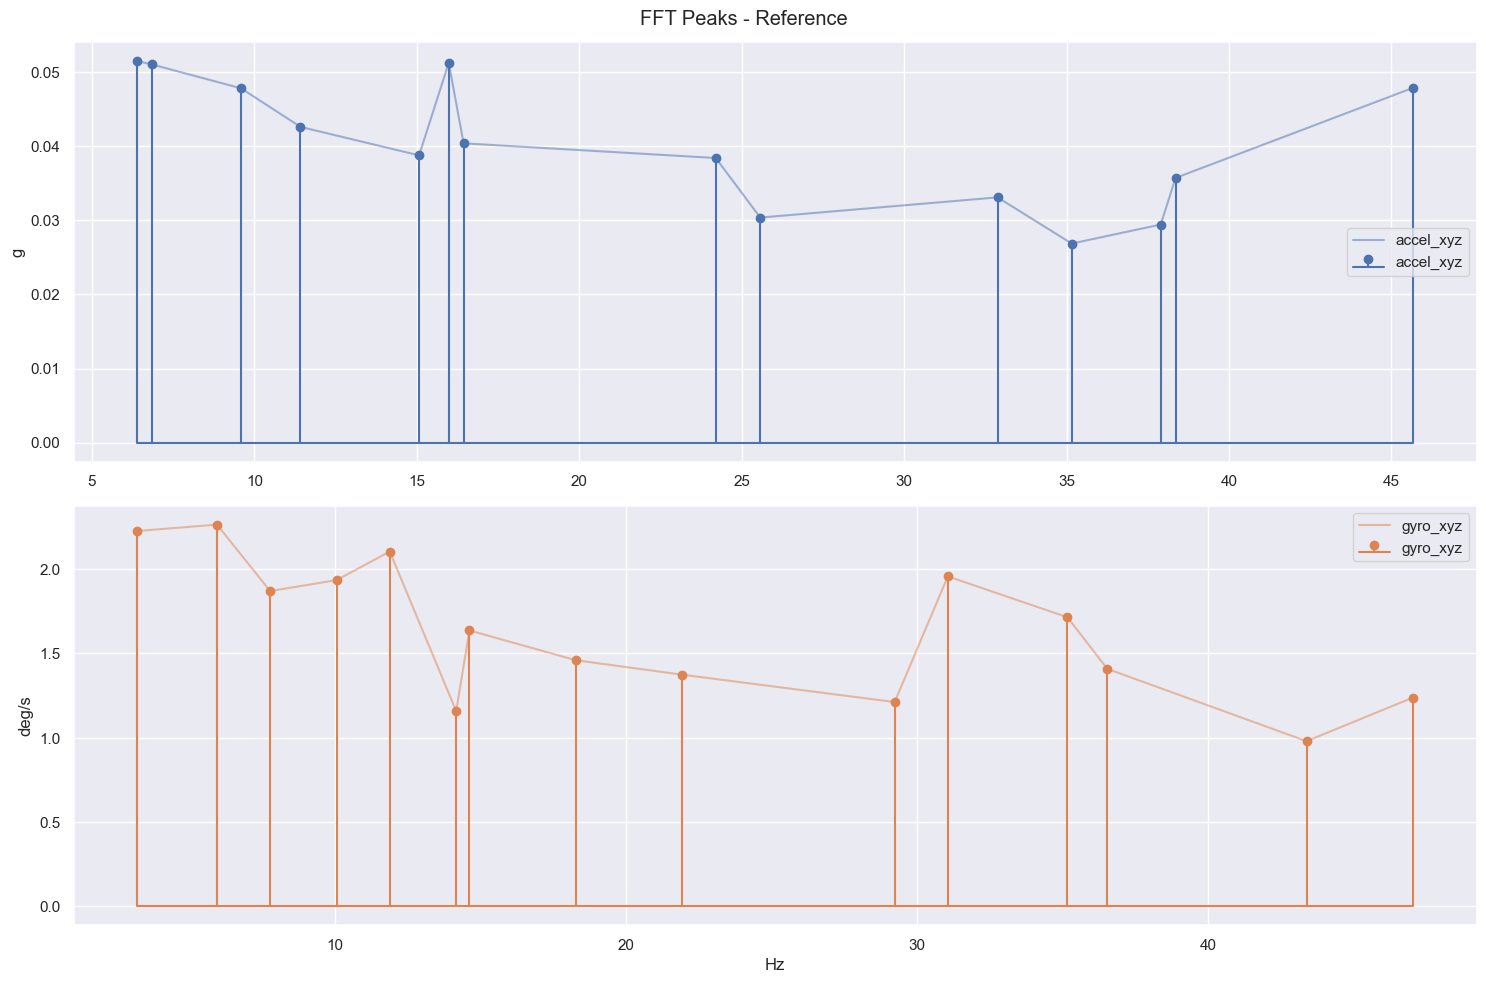

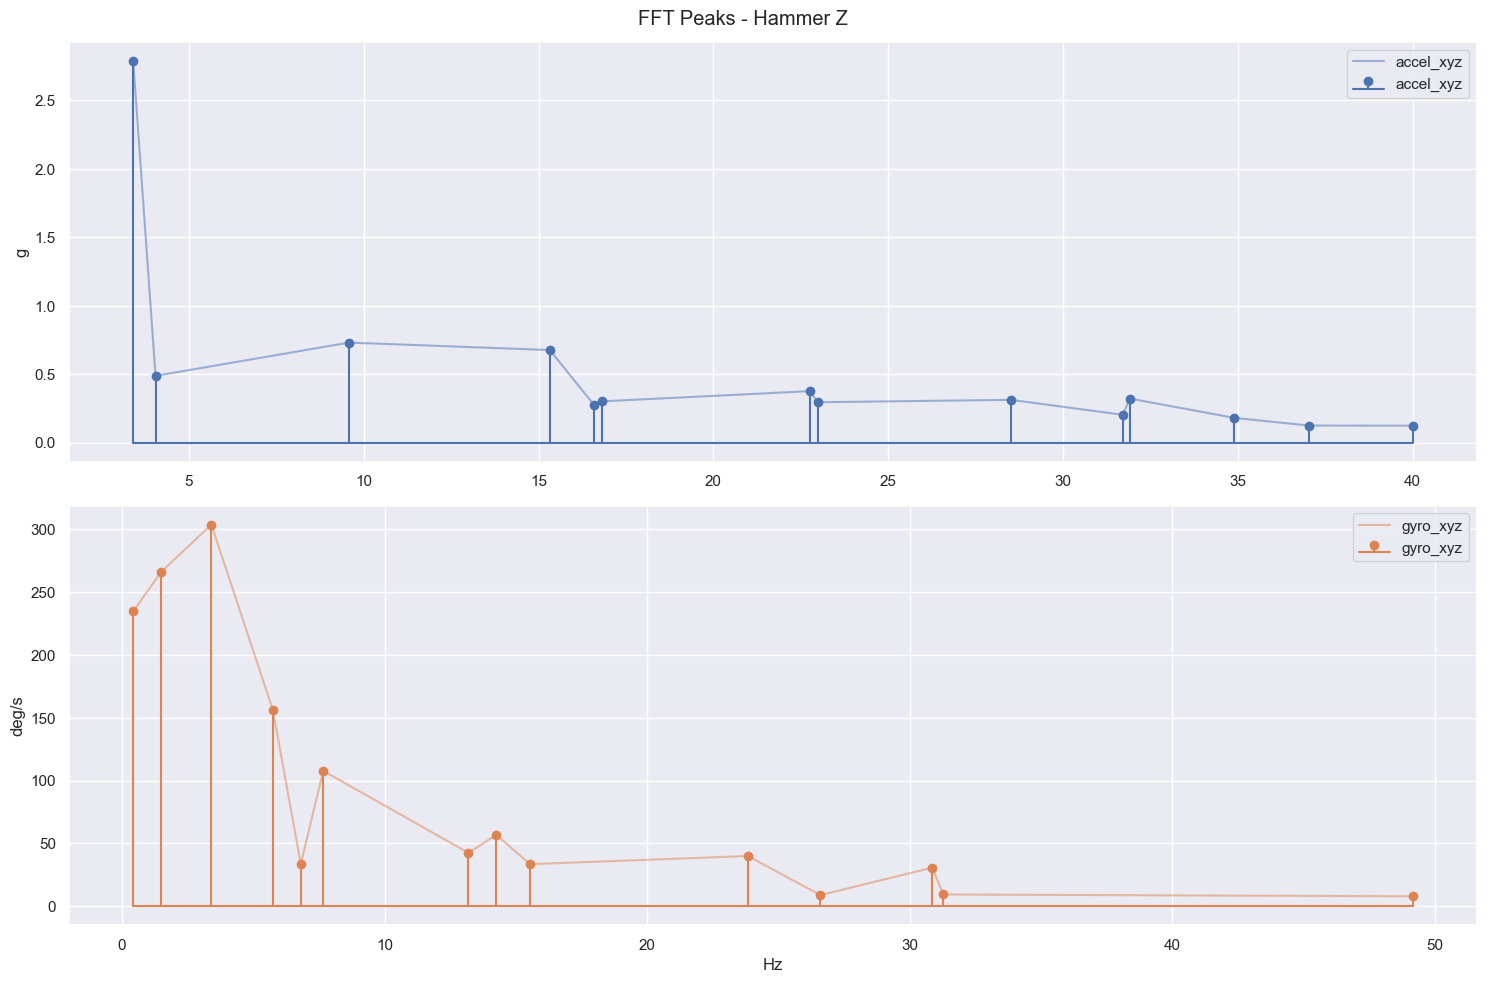

In [194]:
plot_peaks_combined(ref_fft[0], title="Reference")
# plot_peaks_combined(floatingx_fft[0], title="Floating X")
# plot_peaks_combined(floatingy_fft[0], title="Floating Y")
# plot_peaks_combined(floatingz_fft[0], title="Floating Z")
plot_peaks_combined(hammerx_fft[0], title="Hammer X")
plot_peaks_combined(hammery_fft[0], title="Hammer Y")
plot_peaks_combined(hammerz_fft[0], title="Hammer Z")
# plot_peaks_combined(impactx_fft[0], title="Impact X")
# plot_peaks_combined(impacty_fft[0], title="Impact Y")
# plot_peaks_combined(impactz_fft[0], title="Impact Z")
# plot_peaks_combined(rotationx_fft[0], title="Rotation X")
# plot_peaks_combined(rotationy_fft[0], title="Rotation Y")
# plot_peaks_combined(rotationz_fft[0], title="Rotation Z")

In [195]:
accel_floatingx_zip = zip_peaks_freq(floatingx_fft[0]['accel_peaks_freq'], floatingx_fft[0]['accel_peaks'])
gyro_floatingx_zip = zip_peaks_freq(floatingx_fft[0]['gyro_peaks_freq'], floatingx_fft[0]['gyro_peaks'])
accel_floatingy_zip = zip_peaks_freq(floatingy_fft[0]['accel_peaks_freq'], floatingy_fft[0]['accel_peaks'])
gyro_floatingy_zip = zip_peaks_freq(floatingy_fft[0]['gyro_peaks_freq'], floatingy_fft[0]['gyro_peaks'])
accel_floatingz_zip = zip_peaks_freq(floatingz_fft[0]['accel_peaks_freq'], floatingz_fft[0]['accel_peaks'])
gyro_floatingz_zip = zip_peaks_freq(floatingz_fft[0]['gyro_peaks_freq'], floatingz_fft[0]['gyro_peaks'])
accel_hammerx_zip = zip_peaks_freq(hammerx_fft[0]['accel_peaks_freq'], hammerx_fft[0]['accel_peaks'])
gyro_hammerx_zip = zip_peaks_freq(hammerx_fft[0]['gyro_peaks_freq'], hammerx_fft[0]['gyro_peaks'])
accel_hammery_zip = zip_peaks_freq(hammery_fft[0]['accel_peaks_freq'], hammery_fft[0]['accel_peaks'])
gyro_hammery_zip = zip_peaks_freq(hammery_fft[0]['gyro_peaks_freq'], hammery_fft[0]['gyro_peaks'])
accel_hammerz_zip = zip_peaks_freq(hammerz_fft[0]['accel_peaks_freq'], hammerz_fft[0]['accel_peaks'])
gyro_hammerz_zip = zip_peaks_freq(hammerz_fft[0]['gyro_peaks_freq'], hammerz_fft[0]['gyro_peaks'])
accel_impactx_zip = zip_peaks_freq(impactx_fft[0]['accel_peaks_freq'], impactx_fft[0]['accel_peaks'])
gyro_impactx_zip = zip_peaks_freq(impactx_fft[0]['gyro_peaks_freq'], impactx_fft[0]['gyro_peaks'])
accel_impacty_zip = zip_peaks_freq(impacty_fft[0]['accel_peaks_freq'], impacty_fft[0]['accel_peaks'])
gyro_impacty_zip = zip_peaks_freq(impacty_fft[0]['gyro_peaks_freq'], impacty_fft[0]['gyro_peaks'])
accel_impactz_zip = zip_peaks_freq(impactz_fft[0]['accel_peaks_freq'], impactz_fft[0]['accel_peaks'])
gyro_impactz_zip = zip_peaks_freq(impactz_fft[0]['gyro_peaks_freq'], impactz_fft[0]['gyro_peaks'])
accel_rotationx_zip = zip_peaks_freq(rotationx_fft[0]['accel_peaks_freq'], rotationx_fft[0]['accel_peaks'])
gyro_rotationx_zip = zip_peaks_freq(rotationx_fft[0]['gyro_peaks_freq'], rotationx_fft[0]['gyro_peaks'])
accel_rotationy_zip = zip_peaks_freq(rotationy_fft[0]['accel_peaks_freq'], rotationy_fft[0]['accel_peaks'])
gyro_rotationy_zip = zip_peaks_freq(rotationy_fft[0]['gyro_peaks_freq'], rotationy_fft[0]['gyro_peaks'])
accel_rotationz_zip = zip_peaks_freq(rotationz_fft[0]['accel_peaks_freq'], rotationz_fft[0]['accel_peaks'])
gyro_rotationz_zip = zip_peaks_freq(rotationz_fft[0]['gyro_peaks_freq'], rotationz_fft[0]['gyro_peaks'])

sequences_accel = [
    accel_floatingx_zip, accel_floatingy_zip, accel_floatingz_zip,
    accel_hammerx_zip, accel_hammery_zip, accel_hammerz_zip,
    accel_impactx_zip, accel_impacty_zip, accel_impactz_zip,
    accel_rotationx_zip, accel_rotationy_zip, accel_rotationz_zip,
]

sequences_gyro = [
    gyro_floatingx_zip, gyro_floatingy_zip, gyro_floatingz_zip,
    gyro_hammerx_zip, gyro_hammery_zip, gyro_hammerz_zip,
    gyro_impactx_zip, gyro_impacty_zip, gyro_impactz_zip,
    gyro_rotationx_zip, gyro_rotationy_zip, gyro_rotationz_zip,
]

## Data Classification

### Dynamic Time Warping

##### Functions

##### Code

DTW Univariate Distance:  205.7909336105334
DTW Multivariate Distance:  218.45496257617117
DTW Multivariate Normalized Distance:  8.620310893840266


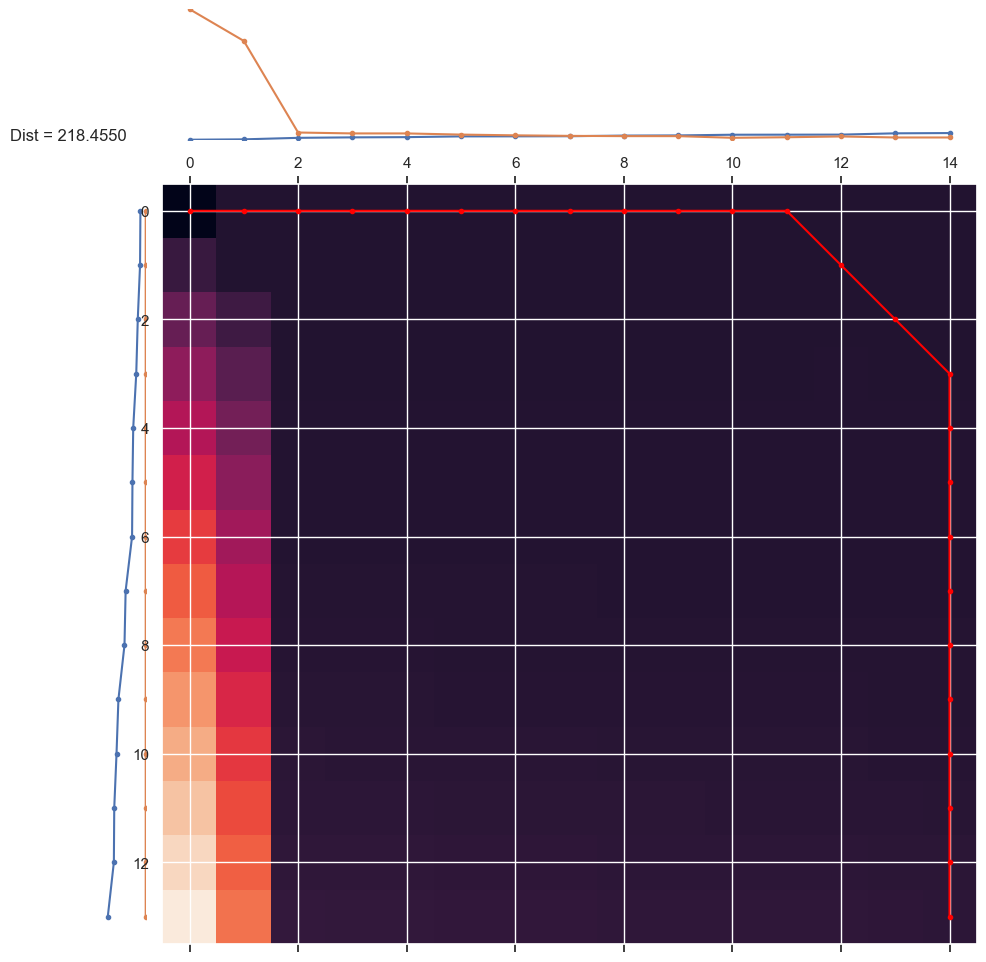

In [196]:
# Calculate the DTW distance between the two sequences
distance = dtw_ndim.distance(ref_fft[0]['accel_peaks'], floatingx_fft[0]['accel_peaks'])
distance_zip = dtw_ndim.distance(zip_peaks_freq(ref_fft[0]['accel_peaks_freq'], ref_fft[0]['accel_peaks']), accel_floatingx_zip)
print("DTW Univariate Distance: ", distance)
print("DTW Multivariate Distance: ", distance_zip)

# plot the univariate warp path
single_path = dtw.warping_path(ref_fft[0]['accel_peaks'], floatingx_fft[0]['accel_peaks'])
dtwvis.plot_warping(ref_fft[0]['accel_peaks'], floatingx_fft[0]['accel_peaks'], single_path)

# plot the cost matrix and the best path
d, paths = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[0]['accel_peaks_freq'], ref_fft[0]['accel_peaks']), accel_floatingx_zip)
best_path = dtw.best_path(paths)

dtwvis.plot_warpingpaths(zip_peaks_freq(ref_fft[0]['accel_peaks_freq'], ref_fft[0]['accel_peaks']), accel_floatingx_zip, paths, best_path)

# normalize the score by dividing the last value of the best path by the length of the best path
score = paths[best_path[-1][0], best_path[-1][1]] / len(best_path)
print("DTW Multivariate Normalized Distance: ", score)

In [200]:
# calculate the DTW distance between the reference and all the other sequences

best_scores = []
for i in range(len(ref_fft)):

    distances = []
    for j in range(len(sequences_accel)):
        d_accel, paths_accel = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[i]['accel_peaks_freq'], ref_fft[i]['accel_peaks']), sequences_accel[j])
        d_gyro, paths_gyro = dtw_ndim.warping_paths(zip_peaks_freq(ref_fft[i]['gyro_peaks_freq'], ref_fft[i]['gyro_peaks']), sequences_gyro[j])
        best_path_accel = dtw.best_path(paths_accel)
        best_path_gyro = dtw.best_path(paths_gyro)
        if len(best_path_accel) == 0 or len(best_path_gyro) == 0:
            score = 99999999
        else:

            score_accel = paths_accel[best_path_accel[-1][0], best_path_accel[-1][1]] / len(best_path_accel)
            score_gyro = paths_gyro[best_path_gyro[-1][0], best_path_gyro[-1][1]] / len(best_path_gyro)
            score = score_accel + score_gyro
            # score = d_accel + d_gyro
        distances.append(score)
    # print(distances)
    best_score = [min(distances), distances.index(min(distances))]
    # print(f"Best score: {best_score[0]} with sequence {best_score[1]}")

    best_scores.append(best_score)

print(f"Lenght scores: {len(best_scores)} - Best scores: {best_scores}")


Lenght scores: 58 - Best scores: [[8.165674514455285, 4], [5.99261334270605, 4], [6.578479978575595, 4], [18.477160782118997, 3], [20.996543472441285, 5], [9.227345007818263, 5], [7.964294893353887, 5], [13.36994358334516, 5], [24.67261453267298, 5], [42.94431925472825, 5], [29.023115612736248, 5], [44.49694625503626, 5], [52.13291065592922, 5], [84.35153480557577, 3], [394.54206838802025, 3], [300.6435191489826, 11], [79.44168357218139, 6], [420.10296632590575, 3], [390.12242906522044, 6], [411.00028293753866, 6], [340.40710150517833, 3], [440.36078510931947, 6], [253.56168529712016, 6], [218.49157242266608, 10], [267.65510334688116, 5], [151.63806820023106, 10], [363.0691661777595, 3], [558.0534425557681, 5], [394.16244163707483, 8], [245.77000616240548, 6], [310.68193607399803, 5], [396.57654694185, 6], [267.13241063129163, 5], [378.2673816891141, 3], [271.937586285793, 3], [184.72614911780965, 5], [305.36355044735586, 3], [391.806655352752, 6], [397.83481471612544, 5], [330.8237008

In [225]:
classes_names = [
    'Floating X', 'Floating Y', 'Floating Z',
    'Hammer X', 'Hammer Y', 'Hammer Z',
    'Impact X', 'Impact Y', 'Impact Z',
    'Rotation X', 'Rotation Y', 'Rotation Z'
]
merged_classes_names = [
    'Floating',
    'Hammer',
    'Impact',
    'Rotation'
]

# Extract classifications from best_scores
classifications = [item[1] for item in best_scores]

# Create a dictionary mapping window ID to classification
window_to_classification = {i: class_id for i, class_id in enumerate(classifications)}

# Define a function to map window IDs to classifications
def get_classifications(window_ids):
    return [window_to_classification.get(window_id) for window_id in window_ids]

# Apply the function to the 'window_id' column to create the 'infer_classes' column
df_ref_over['infer_classes'] = df_ref_over['window_id'].apply(get_classifications)

# Generate a unique color for each classification
unique_classifications = list(set(classifications))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classifications)))  # Using 'tab20' for more distinct colors
color_map = dict(zip(unique_classifications, colors))

# Plotting the histogram with height of 1.0 for each bar
plt.figure(figsize=(15, 7))
for i, classification in enumerate(classifications):
    plt.bar(i, 1.0, color=color_map[classification], edgecolor='None')

# Creating the legend
legend_handles = [mpatches.Patch(color=color_map[cls], label=classes_names[cls]) for cls in unique_classifications]
plt.legend(handles=legend_handles)

# Setting up the axes and labels
plt.xlabel("Window Number")
plt.ylabel("DTW Score")
plt.title("Classification of Each Time Window")
# plt.xticks(range(len(scores)))  # Set x-ticks to be the window numbers

plt.show()


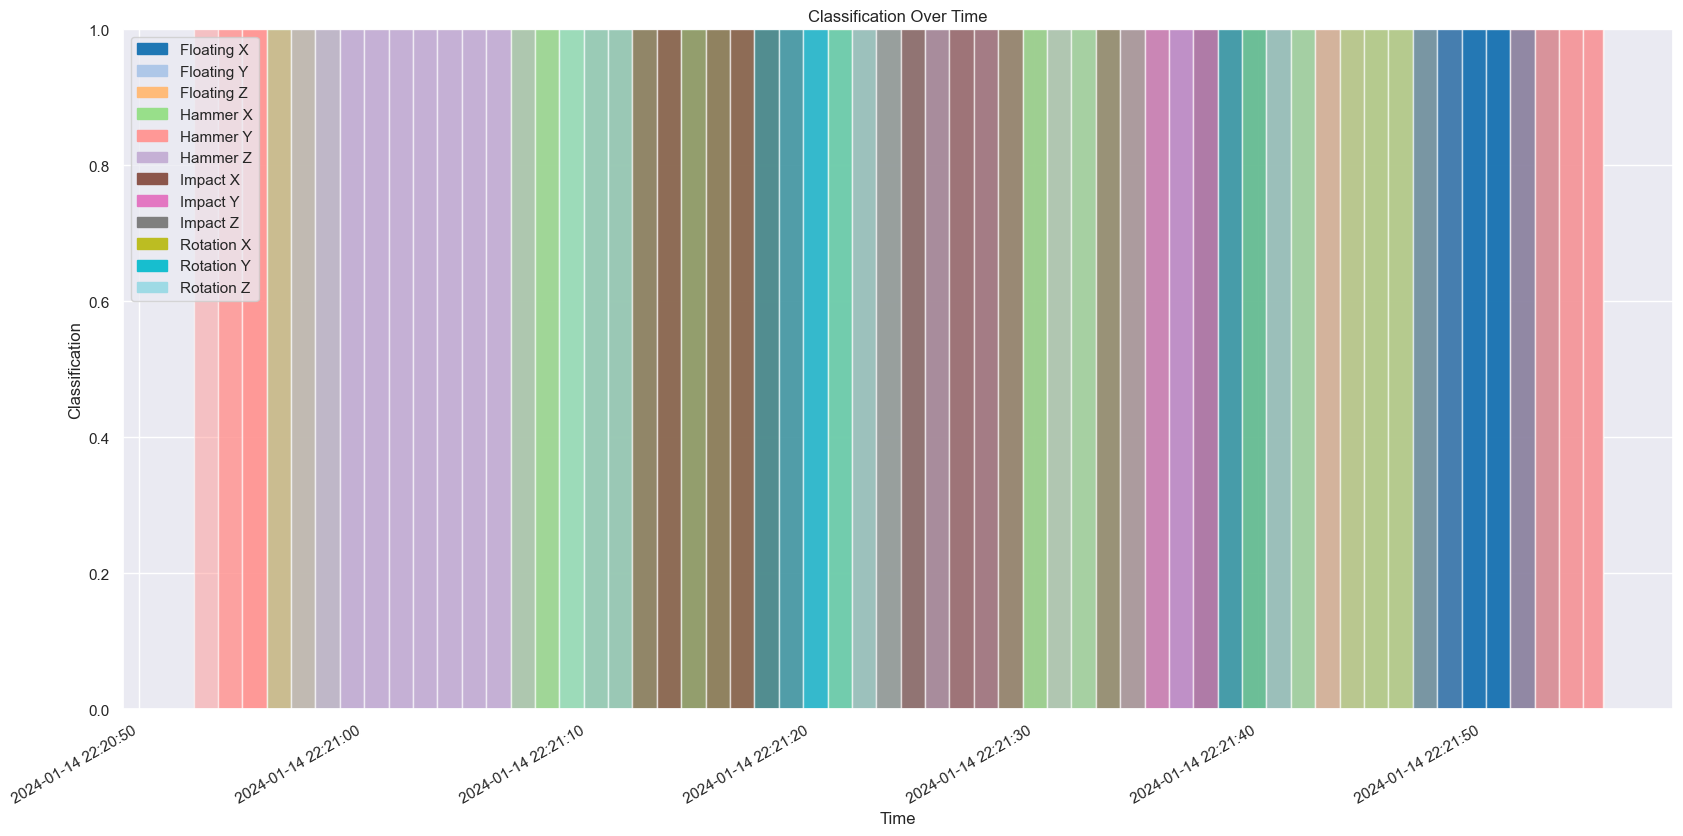

In [219]:
# Create a new DataFrame for plotting purposes
plot_df = pd.DataFrame(index=df_ref_over.index)

# We'll store the start and end times of each window for plotting
window_times = {}

# Go through each row and determine the start and end times of each window
for time, row in df_ref_over.iterrows():
    for window_id in row['window_id']:
        if window_id not in window_times:
            window_times[window_id] = [time, time]
        else:
            window_times[window_id][1] = time

# Now, let's set up the plot
plt.figure(figsize=(20, 10))

# Generate a color for each classification
colors = plt.cm.tab20(np.linspace(0, 1, len(classes_names)))

# Plot a span for each window
for window_id, times in window_times.items():
    # Get the classifications for this window
    class_ids = df_ref_over.loc[times[0], 'infer_classes']
    for class_id in class_ids:
        class_name = classes_names[class_id]
        color = colors[class_id]
        plt.axvspan(times[0], times[1], facecolor=color, alpha=0.5, label=class_name)

# Beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Add legend handles - we create a patch for each class
handles = [plt.Rectangle((0,0),1,1, color=colors[class_id], label=class_name) for class_id, class_name in enumerate(classes_names)]
plt.legend(handles=handles)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Classification")
plt.title("Classification Over Time")

plt.grid(True)

plt.show()


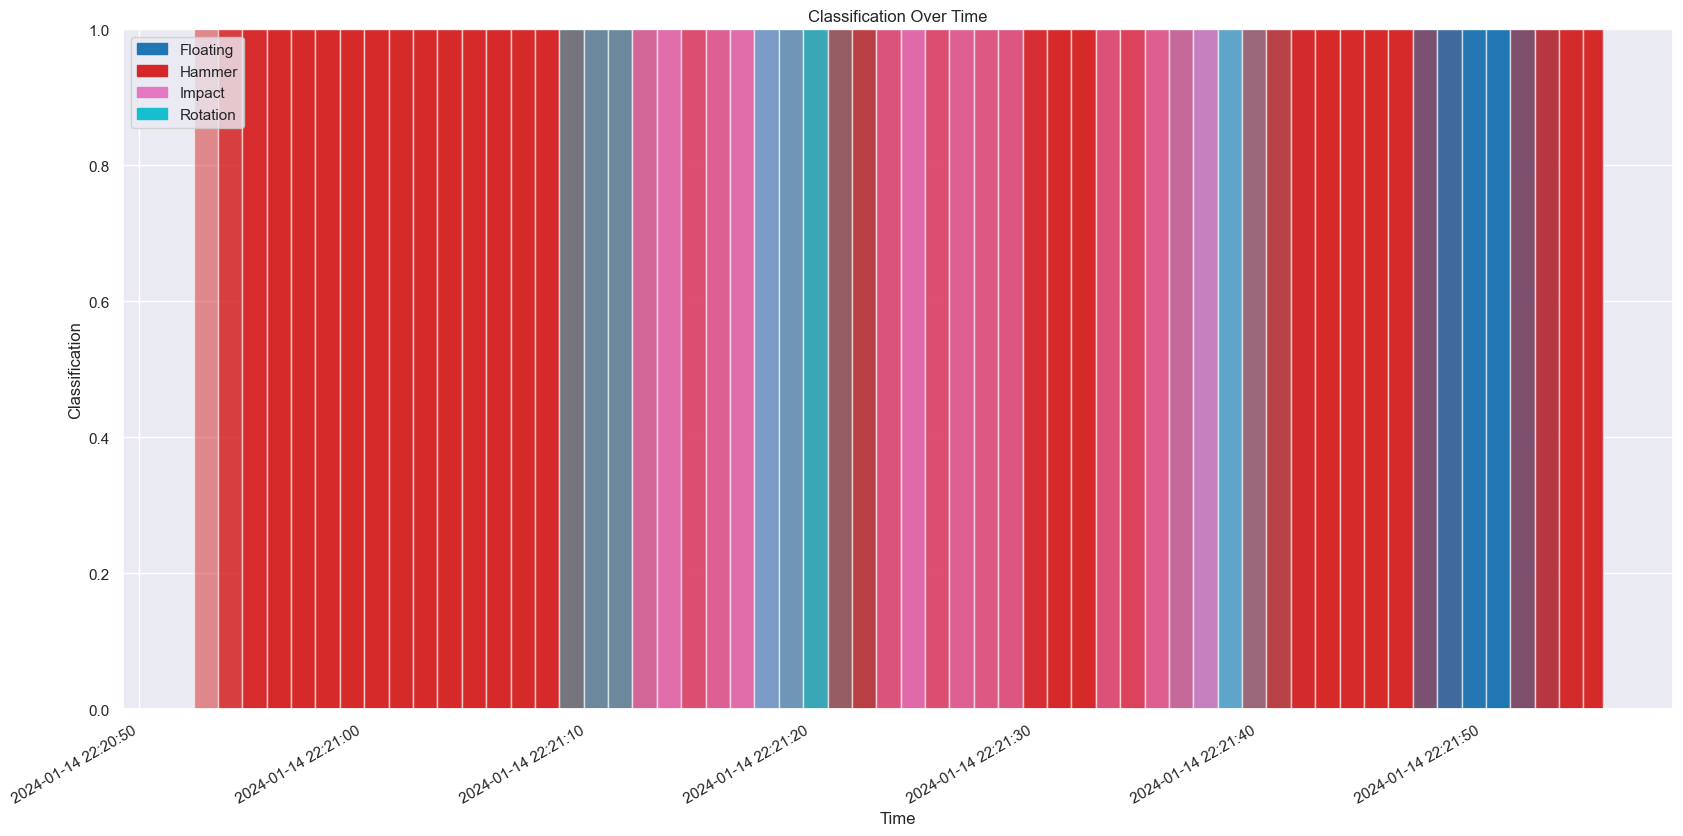

In [226]:
# We'll store the start and end times of each window for plotting
window_times = {}

# Go through each row and determine the start and end times of each window
for time, row in df_ref_over.iterrows():
    for window_id in row['window_id']:
        if window_id not in window_times:
            window_times[window_id] = [time, time]
        else:
            window_times[window_id][1] = time

# Now, let's set up the plot
plt.figure(figsize=(20, 10))

# Generate a color for every three classes
group_size = 3  # Number of classes to merge into one color
num_groups = (len(classes_names) + group_size - 1) // group_size  # Calculate the number of groups
colors = plt.cm.tab10(np.linspace(0, 1, num_groups))  # Use tab10 or another colormap as needed

# Plot a span for each window
for window_id, times in window_times.items():
    # Ensure class_ids is a list, even if it's a single integer
    class_ids = df_ref_over.loc[times[0], 'infer_classes']
    if isinstance(class_ids, int):
        class_ids = [class_ids]  # Make it a list if it's not

    # Determine the group color for each class_id
    for class_id in class_ids:
        group_id = class_id // group_size  # Integer division to find the group
        color = colors[group_id]  # Assign color by group
        plt.axvspan(times[0], times[1], facecolor=color, alpha=0.5)

# Beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Add legend handles - create a patch for each group of classes
handles = [plt.Rectangle((0,0),1,1, color=colors[i], label=merged_classes_names[i]) for i in range(num_groups)]
plt.legend(handles=handles)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Classification")
plt.title("Classification Over Time")

plt.grid(True)

plt.show()

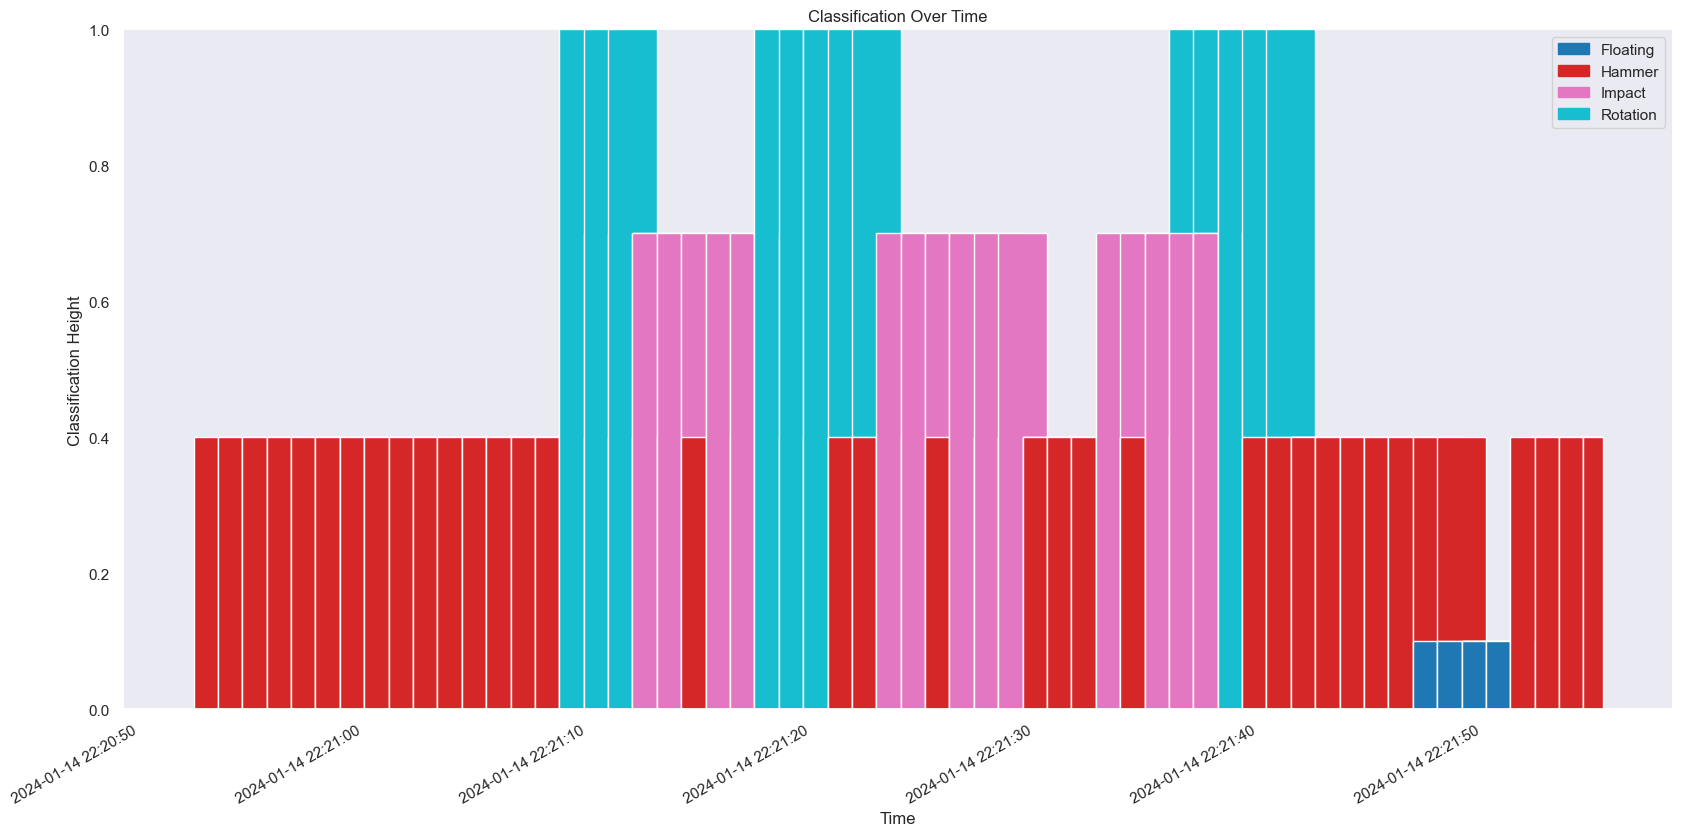

In [236]:
# We'll store the start and end times of each window for plotting
window_times = {}

# Go through each row and determine the start and end times of each window
for time, row in df_ref_over.iterrows():
    for window_id in row['window_id']:
        if window_id not in window_times:
            window_times[window_id] = [time, time]
        else:
            window_times[window_id][1] = time

# Now, let's set up the plot
plt.figure(figsize=(20, 10))

# Generate a color and height for every three classes
group_size = 3  # Number of classes to merge into one group
num_groups = (len(classes_names) + group_size - 1) // group_size  # Calculate the number of groups
colors = plt.cm.tab10(np.linspace(0, 1, num_groups))  # Use tab10 or another colormap as needed

# Define the heights for each group
heights = np.linspace(0.1, 1, num_groups)

# Plot a span for each window
for window_id, times in window_times.items():
    # Ensure class_ids is a list, even if it's a single integer
    class_ids = df_ref_over.loc[times[0], 'infer_classes']
    if isinstance(class_ids, int):
        class_ids = [class_ids]  # Make it a list if it's not

    # Determine the group color and height for each class_id
    for class_id in class_ids:
        group_id = class_id // group_size  # Integer division to find the group
        color = colors[group_id]  # Assign color by group
        height = heights[group_id]  # Assign height by group
        plt.axvspan(times[0], times[1], ymin=0, ymax=height, facecolor=color, label=f'Group {group_id+1}', alpha=1)
        # plt.axvspan(times[0], times[1], ymin=0, ymax=height, facecolor=color, label=f'Group {group_id+1}', alpha=1, zorder=-group_id)

# Beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Add legend handles - create a patch for each group of classes
handles = [plt.Rectangle((0,0),1,1, color=colors[i], label=merged_classes_names[i]) for i in range(num_groups)]
plt.legend(handles=handles)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Classification Height")
plt.title("Classification Over Time")

plt.grid(False)

plt.show()

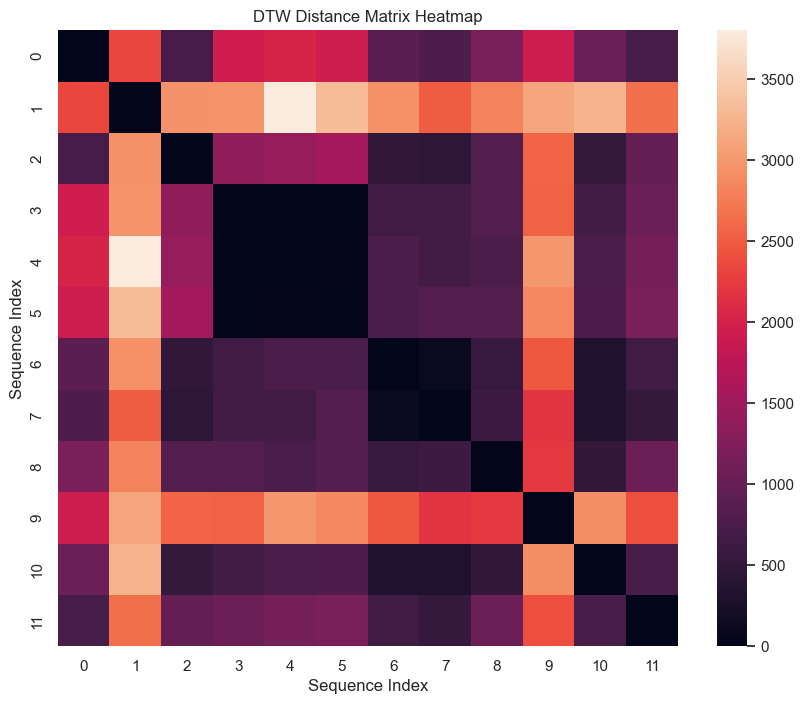

In [91]:

# Initialize a 12x12 matrix of zeros for the distances
distance_matrix = np.zeros((len(sequences_accel), len(sequences_accel)))

# Calculate the DTW distance between each pair of sequences
for i in range(len(sequences_accel)):
    for j in range(len(sequences_accel)):
        if i != j:  # No need to calculate when i == j since the distance is zero
            d_accel, paths_accel = dtw_ndim.warping_paths(sequences_accel[i], sequences_accel[j])
            d_gyro, paths_gyro = dtw_ndim.warping_paths(sequences_gyro[i], sequences_gyro[j])
            best_path_accel = dtw.best_path(paths_accel)
            best_path_gyro = dtw.best_path(paths_gyro)
            if len(best_path_accel) == 0 or len(best_path_gyro) == 0:
                score = 99999999
            else:

                score_accel = paths_accel[best_path_accel[-1][0], best_path_accel[-1][1]] / len(best_path_accel)
                score_gyro = paths_gyro[best_path_gyro[-1][0], best_path_gyro[-1][1]] / len(best_path_gyro)
                score = score_accel + score_gyro

            distance_matrix[i, j] = score

# Now, create a heatmap from the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, fmt=".2f")
plt.title('DTW Distance Matrix Heatmap')
plt.xlabel('Sequence Index')
plt.ylabel('Sequence Index')
plt.show()